<table style="width: 100%; margin-left: auto; margin-right: auto; background-color: white;">
<tbody>
<tr>

<td style="text-align: center; width: 12%;"><img src="imagens/brasil-brasao.png" alt="" /></td>

<td style="width: 68%;">
<h2 style="text-align: center; margin-top: 1%;">Governo do Brasil</h2>
<h2 style="text-align: center; margin-top: 1%;">Minist&eacute;rio da Educa&ccedil;&atilde;o</h2>
<h2 style="text-align: center; margin-top: 1%;">Universidade Federal do Amazonas</h2>
<h2 style="text-align: center; margin-top: 1%;">Instituto de Computa&ccedil;&atilde;o</h2>
</td>

<td style="width: 12%;"><img src="imagens/UFAM-logo.png" alt="" /></td>

</tr>
</tbody>
</table>

# Aprendizado de Máquina e Mineração de Dados
## Projeto Final de Disciplina, v. 1.0

Professores _Marco Cristo_ e _Eulanda Santos_

**Alunos**:

- Carlos Vicente Soares Araujo
- Thiago Marques Rocha

Neste trabalho, você vai usar dados do INEP sobre o ENADE 2014 realizado por alunos de Pedagogia da região Sudeste do Brasil. Os dados a serem usados estão descritos em anexo a este documento e serão disponibilizados com o trabalho. Seu objetivo é prever se um aluno vai ou não passar no ENADE, ou seja, se sua nota média geral (NT_GER) será maior que 50. 

__Requisitos__:

* A solução deve ser feita usando as biliotecas sklearn, tensorflow e keras;
* O relatório deve ser entregue como um notebook Jupyter;
* O relatório deve incluir todos os passos de transformação de dados executados;
* Devem ser apresentados os seguintes modelos:
    * RandomForest;
    * Rede Neural com pelo menos duas camadas ocultas;
        * Modelo simples;
        * Modelo com normalização em batch;
        * Modelo com Dropout;
* Todos os modelos acima devem ser avaliados sob as mesmas condições;
    
__Avaliação__:

* 80% da nota associado ao trabalho entregue;
* 20% da nota associado ao resultado obtido pelos modelos;
    
__Observações__:

* Trabalho para equipes de até duas pessoas;
* Códigos-base em Keras para a FNN são fornecidos abaixo;

# Códigos base para implementação de rede neural em Keras

In [3]:
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score as sklearn_roc_auc_score
from sklearn.metrics import accuracy_score as sklearn_accuracy_score
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

In [4]:
from IPython.display import display
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
# %matplotlib inline 
pd.options.mode.chained_assignment = None  # default='warn'

In [236]:
from keras import backend as K
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Nadam, SGD
from keras.callbacks import EarlyStopping

Aqui definimos uma função de impressão para o objeto history retornado pela execução das redes. Imprimos aqui um gráfico contendo as perdas tanto da base de teste, quanto da de treino.

In [6]:
def plot_model_history(model_history):
    # summarize history for loss
    plt.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    plt.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='best')
    plt.show()

In [89]:
def train_model(model, X_train, X_test, y_train, y_test, 
                bsize = 200, n_epochs = 1000, val_proportion = 0.2, patience = 20):

    # estratégia de treino com parada antecipada consiste em parar o treino
    # quando nenhuma melhoria no erro de validação (val_loss) é observada após
    # "patience" épocas
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=patience, \
                verbose=1, mode='auto')
    callback_list = [earlystop]
    
    # Modelo usa parâmetros comuns que podem ser modificados
    h = model.fit(X_train, y_train, batch_size=bsize, epochs=n_epochs,
                  verbose=2, shuffle = True, callbacks = callback_list, 
                  validation_split=val_proportion)
    plot_model_history(h)          
    
    evaluate("Neural Network", model, X_test, y_test)
    
    return model

### Código base para Random Forest

In [9]:
def get_random_forest_model(X_train, y_train, n_estimators=10, random_state=0):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    model.fit(X_train, y_train) # train model
    return model

### Código base para avaliação

In [10]:
RANDOM_FOREST = "Random Forest"
NEURAL_NETWORK = "Neural Network"

In [11]:
# Avalia a os modelos
def evaluate(name, model, X_test, y_test):
    print(model)
    # avaliação somente no teste
    print('\nEstimating AUCROC, acc')
    y_pred = model.predict(X_test)
    print('ROC value: {:.2f}%'.format(sklearn_roc_auc_score(y_test, y_pred) * 100.0))
    if name == RANDOM_FOREST:
        print('Acc: {:.2f}%'.format(sklearn_accuracy_score(y_test, y_pred) * 100.0))
        print('CMatrix: \n{}'.format(sklearn_confusion_matrix(y_test, y_pred)))
    elif name == NEURAL_NETWORK:
        print('Acc: {:.2f}'.format(sklearn_accuracy_score(y_test, y_pred>0.5) * 100.0))
        print('CMatrix: \n%s'%(sklearn_confusion_matrix(y_test, y_pred>0.5)))

## Exploração dos dados

Dataset *e2014pedse.csv* com as informações sobre o ENADE 2014 

In [12]:
df = pd.read_csv('e2014pedse.csv')

#### Total de instâncias

In [13]:
len(df)

38121

### Colunas

Temos as colunas referente a:

- IES
- Candidatos dados
- Candidatos notas
- Questionários curso, candidatos e prova

Para cada um dessas colunas será criado um dataframe separado para faciliar a análise de cada um

In [14]:
# Features
df.keys().values

array(['CO_IES', 'CO_CATEGAD', 'CO_ORGACAD', 'CO_GRUPO', 'CO_CURSO',
       'CO_UF_CURSO', 'CO_REGIAO_CURSO', 'NU_IDADE', 'TP_SEXO',
       'ANO_FIM_2G', 'ANO_IN_GRAD', 'IN_MATUT', 'IN_VESPER', 'IN_NOTURNO',
       'ID_STATUS', 'NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG',
       'NT_FG_D1', 'NT_FG_D1_PT', 'NT_FG_D1_CT', 'NT_FG_D2',
       'NT_FG_D2_PT', 'NT_FG_D2_CT', 'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE',
       'NT_CE_D1', 'NT_CE_D2', 'NT_CE_D3', 'QE_I01', 'QE_I02', 'QE_I03',
       'QE_I04', 'QE_I05', 'QE_I06', 'QE_I07', 'QE_I08', 'QE_I09',
       'QE_I10', 'QE_I11', 'QE_I12', 'QE_I13', 'QE_I14', 'QE_I15',
       'QE_I16', 'QE_I17', 'QE_I18', 'QE_I19', 'QE_I20', 'QE_I21',
       'QE_I22', 'QE_I23', 'QE_I24', 'QE_I25', 'QE_I26', 'QE_I27',
       'QE_I28', 'QE_I29', 'QE_I30', 'QE_I31', 'QE_I32', 'QE_I33',
       'QE_I34', 'QE_I35', 'QE_I36', 'QE_I37', 'QE_I38', 'QE_I39',
       'QE_I40', 'QE_I41', 'QE_I42', 'QE_I43', 'QE_I44', 'QE_I45',
       'QE_I46', 'QE_I47', 'QE_I48', 'QE_I49', 'QE_I

### Dados IES

In [276]:
df_ies = df[['CO_IES', 'CO_CATEGAD', 'CO_ORGACAD', 'CO_GRUPO', 'CO_CURSO',
       'CO_UF_CURSO', 'CO_REGIAO_CURSO']]

df_ies.head()

,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO
0,8,10002,10028,2001,697,MG,3
1,8,10002,10028,2001,697,MG,3
2,8,10002,10028,2001,697,MG,3
3,8,10002,10028,2001,697,MG,3
4,8,10002,10028,2001,697,MG,3


In [252]:
df_ies.describe(include='all')

,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO
count,38121.000000,38121.000000,38121.000000,38121.0,3.812100e+04,38121,38121.0
unique,NaN,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,NaN,NaN,NaN,SP,NaN
freq,NaN,NaN,NaN,NaN,NaN,26697,NaN
mean,1117.669395,10006.184649,10025.009994,2001.0,1.699900e+05,NaN,3.0
std,1499.845401,2.236146,3.381440,0.0,5.032742e+05,NaN,0.0
min,6.000000,10001.000000,10020.000000,2001.0,6.970000e+02,NaN,3.0
25%,322.000000,10005.000000,10022.000000,2001.0,5.112100e+04,NaN,3.0
50%,547.000000,10008.000000,10028.000000,2001.0,9.665500e+04,NaN,3.0
75%,1300.000000,10008.000000,10028.000000,2001.0,1.033380e+05,NaN,3.0


### Dados de candidatos

In [380]:
df_dados_candidatos = df[['NU_IDADE', 'TP_SEXO', 'ANO_FIM_2G', 'ANO_IN_GRAD', 
                          'IN_MATUT', 'IN_VESPER', 'IN_NOTURNO', 'ID_STATUS']]

df_dados_candidatos.head()

,NU_IDADE,TP_SEXO,ANO_FIM_2G,ANO_IN_GRAD,IN_MATUT,IN_VESPER,IN_NOTURNO,ID_STATUS
0,27,F,2004,2009,0,0,1,1
1,23,F,2008,2010,0,0,1,1
2,22,F,2009,2010,0,0,1,1
3,32,F,1999,2010,0,0,1,1
4,21,F,2010,2011,0,0,1,1


In [100]:
df_dados_candidatos.describe(include='all')

,NU_IDADE,TP_SEXO,ANO_FIM_2G,ANO_IN_GRAD,IN_MATUT,IN_VESPER,IN_NOTURNO,ID_STATUS
count,38121.000000,38121,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.0
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,36039,NaN,NaN,NaN,NaN,NaN,NaN
mean,33.378348,NaN,2001.733795,2011.341596,0.183521,0.098607,0.797592,1.0
std,9.377626,NaN,7.881778,1.194730,0.387098,0.298138,0.401800,0.0
min,19.000000,NaN,1963.000000,1989.000000,0.000000,0.000000,0.000000,1.0
25%,25.000000,NaN,1997.000000,2011.000000,0.000000,0.000000,1.000000,1.0
50%,32.000000,NaN,2003.000000,2011.000000,0.000000,0.000000,1.000000,1.0
75%,40.000000,NaN,2008.000000,2012.000000,0.000000,0.000000,1.000000,1.0


### Distribuição de NU_IDADE, ANO_FIM_2G e ANO_IN_GRAD

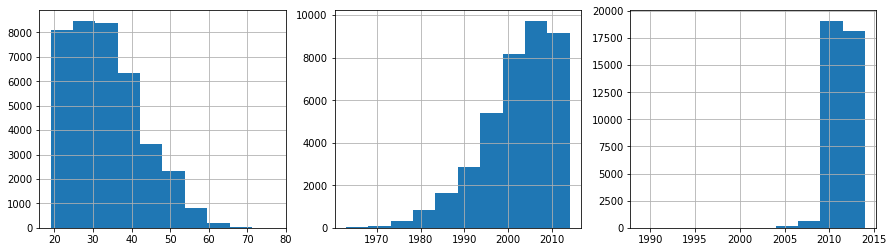

In [101]:
fig, eixos = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
df_dados_candidatos['NU_IDADE'].hist(ax=eixos[0])
df_dados_candidatos['ANO_FIM_2G'].hist(ax=eixos[1])
df_dados_candidatos['ANO_IN_GRAD'].hist(ax=eixos[2])

### Nota dos candidatos

In [278]:
df_notas_candidatos = df[['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_PT',
       'NT_FG_D1_CT', 'NT_FG_D2', 'NT_FG_D2_PT', 'NT_FG_D2_CT', 'NT_CE',
       'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NT_CE_D2', 'NT_CE_D3', 'NT_INST']]

df_notas_candidatos.head()

,NT_GER,NT_FG,NT_OBJ_FG,NT_DIS_FG,NT_FG_D1,NT_FG_D1_PT,NT_FG_D1_CT,NT_FG_D2,NT_FG_D2_PT,NT_FG_D2_CT,NT_CE,NT_OBJ_CE,NT_DIS_CE,NT_CE_D1,NT_CE_D2,NT_CE_D3,NT_INST
0,67.4,83.4,75.0,96.0,95.0,75.0,100.0,97.0,85.0,100.0,62.1,72.7,1.7,5.0,0.0,0.0,0.721951
1,68.9,65.5,62.5,70.0,76.0,60.0,80.0,64.0,80.0,60.0,70.0,72.7,55.0,65.0,30.0,70.0,0.800000
2,53.7,44.2,25.0,73.0,51.0,55.0,50.0,95.0,75.0,100.0,56.8,63.6,18.3,0.0,25.0,30.0,0.942857
3,65.8,74.2,75.0,73.0,67.0,55.0,70.0,79.0,75.0,80.0,63.0,68.2,33.3,50.0,30.0,20.0,0.833333
4,56.5,47.0,50.0,42.5,34.0,70.0,25.0,51.0,75.0,45.0,59.6,63.6,36.7,55.0,25.0,30.0,0.690476


In [103]:
df_notas_candidatos.describe(include='all')

,NT_GER,NT_FG,NT_OBJ_FG,NT_DIS_FG,NT_FG_D1,NT_FG_D1_PT,NT_FG_D1_CT,NT_FG_D2,NT_FG_D2_PT,NT_FG_D2_CT,NT_CE,NT_OBJ_CE,NT_DIS_CE,NT_CE_D1,NT_CE_D2,NT_CE_D3,NT_INST
count,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000,38121.000000
mean,49.367577,53.017035,50.260355,57.152055,55.988799,61.705753,54.584088,58.315312,62.396186,57.333622,48.134503,51.692797,27.955492,31.520815,21.102935,31.241835,0.837064
std,14.711028,15.856634,20.136057,18.745720,24.538560,18.163598,28.481106,23.122572,16.466838,26.894898,16.343035,18.267450,14.018290,19.695116,18.712635,23.719577,0.174525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.500000,42.000000,37.500000,45.000000,39.000000,55.000000,30.000000,46.000000,55.000000,45.000000,36.200000,36.400000,18.300000,20.000000,10.000000,10.000000,0.752381
50%,49.500000,53.200000,50.000000,59.000000,58.000000,65.000000,55.000000,62.000000,65.000000,60.000000,48.200000,50.000000,26.700000,30.000000,15.000000,30.000000,0.885714
75%,60.200000,64.300000,62.500000,71.000000,75.000000,75.000000,75.000000,77.000000,75.000000,80.000000,60.300000,63.600000,36.700000,45.000000,30.000000,50.000000,0.978947
max,92.200000,99.400000,100.000000,98.500000,100.000000,100.000000,100.000000,99.000000,95.000000,100.000000,95.000000,100.000000,88.300000,100.000000,100.000000,100.000000,1.000000


### Questionário sobre candidatos, curso e prova

In [279]:
df_questionarios = df[df.filter(regex='QE').keys()]

df_questionarios.head()

,QE_I01,QE_I02,QE_I03,QE_I04,QE_I05,QE_I06,QE_I07,QE_I08,QE_I09,QE_I10,...,QE_I59,QE_I60,QE_I61,QE_I62,QE_I63,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68
0,A,A,A,B,D,D,A,A,B,A,...,6.0,1.0,6.0,5.0,5.0,5.0,8.0,5.0,4.0,6.0
1,A,A,A,C,E,D,C,C,C,C,...,6.0,3.0,4.0,5.0,5.0,6.0,4.0,6.0,6.0,6.0
2,A,A,A,C,B,B,B,A,B,A,...,6.0,4.0,5.0,5.0,5.0,4.0,4.0,6.0,6.0,6.0
3,A,B,A,B,C,D,C,A,B,A,...,5.0,5.0,5.0,5.0,5.0,6.0,5.0,6.0,5.0,5.0
4,A,A,A,D,B,E,A,A,B,A,...,5.0,1.0,2.0,2.0,2.0,4.0,1.0,5.0,4.0,4.0


In [280]:
df.filter(regex='CO_RS').keys()

Index([], dtype='object')

**Obs**: Não foi possível encontrar as colunas refente ao questionário sobre a prova de prefixo *CO_RS* apesar de constar no anexo

### Qual foi quantidade de candidatos aprovados e não aprovados?

Visualizar quantos candidatos foram aprovados e quantos não foram considerando aprovado candidatos com nota maior que 50

**coluna**: NT_GER

In [281]:
Y = df_notas_candidatos['NT_GER']
Y.head()

0    67.4
1    68.9
2    53.7
3    65.8
4    56.5
Name: NT_GER, dtype: float64

In [282]:
Y.describe()

count    38121.000000
mean        49.367577
std         14.711028
min          0.000000
25%         38.500000
50%         49.500000
75%         60.200000
max         92.200000
Name: NT_GER, dtype: float64

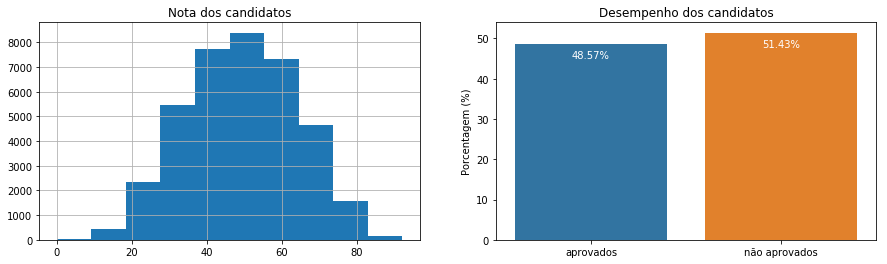

In [376]:
aprovados  = Y[Y > 50]
reprovados = Y[Y <= 50]
total_candidatos = len(Y)

# Dataframe com os candidatos
df_a_r = pd.DataFrame(
    columns=['aprovados', 'não aprovados'],
    data=[[len(aprovados), len(reprovados)]], 
    index=['candidatos']
)

fig, eixos = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
# Distribuicao dos candidatos aprovados e reprovados
ax = Y.hist(ax=eixos[0])
ax.set_title('Nota dos candidatos')
# Porcentagem dos candidatos aprovados e reprovados
ax = sns.barplot(data=df_a_r, estimator=lambda x: (x[0] / total_candidatos) * 100, ax=eixos[1])
ax.set(ylabel="Porcentagem (%)")
ax.set(title='Desempenho dos candidatos')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height - 3.5,
            '{:1.2f}%'.format(height),
            ha="center", color='w') 
# Total de candidatos aprovados e reprovados

Baseado no **histograma** e o gráfico de **barras** dos candidatos, observa-se uma distribuição normal com todo mundo em torno da média de 50 pontos. Assim, a maioria dos candidatos aprovados e não reprovados estão distribuidos a direita e esquerda da média. No gráfico de barras conseguimos ver que existe uma proporção quase equilibrada entre **48.57%** aprovados e **51.43%** não aprovados. Portanto, para o ano de 2014 do ENADE teve **um número maior de candidatos não aprovados** do que aprovados, para o curso de Psicologia.

Nesse sentido a priori sabemos que tem mais chance de um novo candidato X não ser aprovado baseado no índice de aprovação.

## Preparação e engenharia de atributos

Nessa seção preparamos a base para que ela fique de forma a apresentar melhores resultados nos modelos. Aplicaremos processo de normalização, engenharia de atributos e outras técnicas para preparar os dados para a previsão

#### Métodos auxiliares para preparação dos dados

In [378]:
# Auxiliar método para visualizar distruição de dados
def plot_inline_hist(df, feat):
    fig, eixos = plt.subplots(nrows=1, ncols=len(feat), figsize=(15,4))
    # Visualizar a suaviazação
    for i, c in zip(range(len(feat)), feat):
        ax = df[c].hist(ax=eixos[i])
        ax.set_title(c)

### Preprocessar dados de candidatos

#### Suavização de NU_IDADE, ANO_FIM_2G e ANO_IN_GRAD

Como vimos na seção anterior sobre a exploração de dados, os atributos NU_IDADE, ANO_FIM_2G e ANO_IN_GRAD possuem uma distribuição diferente de uma normal. Aplicaremos uma suavização que consiste na técnica de transformação da distribuição atual em uma distribuição normal. Geralmente funções logarítmas, raiz quadrada, potência entre outras funções são usadas pra isso.

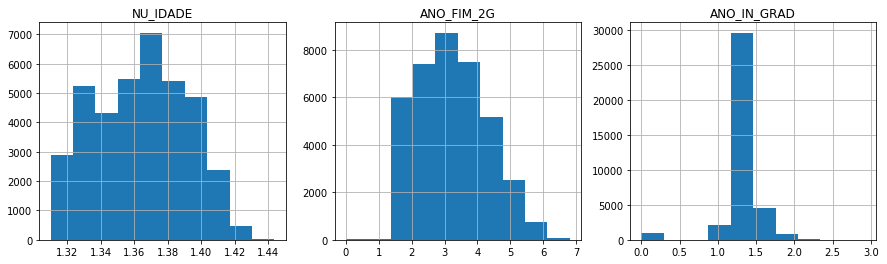

In [381]:
# Suavização
df_dados_candidatos.loc[:, 'NU_IDADE']    = np.power(np.log(df_dados_candidatos['NU_IDADE']), 1.0/4.0)
df_dados_candidatos.loc[:, 'ANO_FIM_2G']  = np.power(np.abs(df_dados_candidatos['ANO_FIM_2G'] - df_dados_candidatos['ANO_FIM_2G'].max()), 1.0/2.05)
df_dados_candidatos.loc[:, 'ANO_IN_GRAD'] = np.power(np.abs(df_dados_candidatos['ANO_IN_GRAD'] - df_dados_candidatos['ANO_IN_GRAD'].max()), 1.0/3.0)
# Plotar a nova distribuição
plot_inline_hist(df_dados_candidatos, ['NU_IDADE', 'ANO_FIM_2G', 'ANO_IN_GRAD'])

#### Categorizar TP_SEXO para numérico {F=0 e M=1} 

In [457]:
for c in ['TP_SEXO']:
    df_dados_candidatos.loc[:,c] = df_dados_candidatos[c].astype('category').cat.codes
print("TP_SEXO categorizado")

TP_SEXO categorizado


#### Normalizar NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD

In [458]:
for c in ['NU_IDADE', 'ANO_FIM_2G', 'ANO_IN_GRAD']:
    df_dados_candidatos.loc[:, c] = (df_dados_candidatos[c] - df_dados_candidatos[c].mean())/df_dados_candidatos[c].std()
print("NU_IDADE', ANO_FIM_2G, ANO_IN_GRAD categorizado")

NU_IDADE', ANO_FIM_2G, ANO_IN_GRAD categorizado


#### Remover ID_STATUS

Removido este atributo porque todos os candaditos possuem o mesmo status (ID_STATUS=1)

In [456]:
if 'ID_STATUS' in df_dados_candidatos.keys():
    df_dados_candidatos.drop('ID_STATUS', axis=1, inplace=True)
print("ID_STATUS removido")

ID_STATUS removido


#### Resultado de NU_INDADE, ANO_FIM_2G e ANO_IN_GRAD normalizado e suavizado

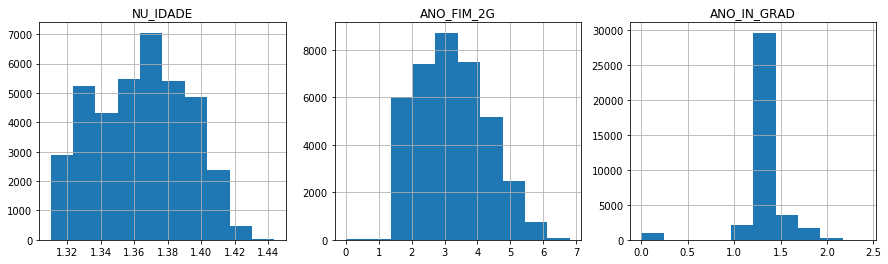

In [447]:
plot_inline_hist(df_dados_candidatos, ['NU_IDADE', 'ANO_FIM_2G', 'ANO_IN_GRAD'])

In [459]:
df_dados_candidatos.head()

,NU_IDADE,TP_SEXO,ANO_FIM_2G,ANO_IN_GRAD,IN_MATUT,IN_VESPER,IN_NOTURNO
0,-0.610002,0,-0.147407,1.341087,0,0,1
1,-1.223989,0,-0.803481,0.897326,0,0,1
2,-1.398364,0,-1.000776,0.897326,0,0,1
3,0.016599,0,0.503138,0.897326,0,0,1
4,-1.582879,0,-1.219545,0.371830,0,0,1


### Preprocessar dados do IES

#### Remover CO_IES

Para evitar o overfitting nos modelos foi removido este atributo, pois este código tem uma variância muito alta praticamente identificando a instituição por um código único

In [289]:
if 'CO_IES' in df_ies.keys():
    df_ies.drop('CO_IES', axis=1, inplace=True)
print("CO_IES removido")

CO_IES removido


#### Remover CO_REGIAO_CURSO

Este campo foi removido porque para todas as instâncias são o mesmo valor, representando a região Sudeste {CO_REGIAO_CURSO=3}

In [291]:
if 'CO_REGIAO_CURSO' in df_ies.keys():
    df_ies.drop('CO_REGIAO_CURSO', axis=1, inplace=True)
print("CO_REGIAO_CURSO removido")

CO_REGIAO_CURSO removido


#### Remover CO_GRUPO

Este campo foi removido porque para todas as instâncias são o mesmo valor, representando os alunos de Psicologia {CO_GRUPO = 2001}

In [292]:
if 'CO_GRUPO' in df_ies.keys():
    df_ies.drop('CO_GRUPO', axis=1, inplace=True)
print("CO_GRUPO removido")

CO_GRUPO removido


#### Remover CO_CURSO

Este campo foi removido pelo mesmo motivo de CO_IES para evitar o overfitting nos modelos devido a alta variância deste atributo que também indentifica o curso igual o CO_IES identifica a instituição.

In [293]:
if 'CO_CURSO' in df_ies.keys():
    df_ies.drop('CO_CURSO', axis=1, inplace=True)
print("CO_CURSO removido")

CO_CURSO removido


#### Categorizar CO_CATEGAD, CO_ORGACAD e CO_UF_CURSO

In [294]:
for c in ['CO_CATEGAD', 'CO_ORGACAD', 'CO_UF_CURSO']:
    df_ies.loc[:, c] = df_ies[c].astype('category').cat.codes
print("CO_CATEGAD, CO_ORGACAD, CO_CURSO e CO_UF_CURSO categorizado")

CO_CATEGAD, CO_ORGACAD, CO_CURSO e CO_UF_CURSO categorizado


#### One hot encoder em CO_CATEGAD, CO_ORGACAD e CO_UF_CURSO

Embora os dados já estejam em formato numérico preferido por muitos métodos, eles ainda não estão tão bons para classificação. Por exemplo, o campo CO_UF_CURSO tem valores numéricos representando cada UF do curso. Isso indica para o classificador que as UF são grandezas numéricas, como a idade, que podem ser comparadas diretamente, mas não é o caso. Pois o classificador deveria entender que uma UF de curso como um tipo de categoria de forma que a UF 17 não é menor que a 25. Elas são meramente diferentes!

Esse processo é chamado de one-hot-enconder para transformar todas as categorias em binários, armazenando presença ou ausência da informação para um determinada categoria.

In [321]:
ies_dummies = {}
for c in ['CO_CATEGAD', 'CO_ORGACAD', 'CO_UF_CURSO']:
    ies_dummies[c] = pd.get_dummies(df_ies[c], prefix=c)

In [322]:
for c in ['CO_CATEGAD', 'CO_ORGACAD', 'CO_UF_CURSO']:
    if c in df_ies.keys():
        df_ies.drop(c, axis=1, inplace=True)
for key in ies_dummies:
    df_ies = df_ies.join(ies_dummies[key])

In [460]:
df_ies.head()

,CO_CATEGAD_0,CO_CATEGAD_1,CO_CATEGAD_2,CO_CATEGAD_3,CO_ORGACAD_0,CO_ORGACAD_1,CO_ORGACAD_2,CO_UF_CURSO_0,CO_UF_CURSO_1,CO_UF_CURSO_2,CO_UF_CURSO_3
0,0,1,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,0
2,0,1,0,0,0,0,1,0,1,0,0
3,0,1,0,0,0,0,1,0,1,0,0
4,0,1,0,0,0,0,1,0,1,0,0


### Preprocessar dados de questionários

#### Categorizar questionários

In [296]:
categoric_questions = df_questionarios.keys()
for c in categoric_questions:
    df_questionarios.loc[:, c] = df_questionarios[c].astype('category').cat.codes
print("Questionários categorizado")

Questionários categorizado


In [344]:
df_questionarios.head()

,QE_I01,QE_I02,QE_I03,QE_I04,QE_I05,QE_I06,QE_I07,QE_I08,QE_I09,QE_I10,...,QE_I59,QE_I60,QE_I61,QE_I62,QE_I63,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68
0,0,0,0,1,3,3,0,0,1,0,...,5,0,5,4,4,4,7,4,3,5
1,0,0,0,2,4,3,2,2,2,2,...,5,2,3,4,4,5,3,5,5,5
2,0,0,0,2,1,1,1,0,1,0,...,5,3,4,4,4,3,3,5,5,5
3,0,1,0,1,2,3,2,0,1,0,...,4,4,4,4,4,5,4,5,4,4
4,0,0,0,3,1,4,0,0,1,0,...,4,0,1,1,1,3,0,4,3,3


#### One hot encoder em questionários

Aplicar o mesmo processo feito nos dados do candidato para não permitir que o classificador compare as respostas dos candidatos achando que a resposta de um questionário, por exemplo, QE_I25 com resposta de número 2 é menor que a resposta de número 5. 

In [345]:
questionsn = {}
for c in categoric_questions:
    questionsn[c] = pd.get_dummies(df_questionarios[c], prefix = c)

In [346]:
df_questionarios = df_questionarios.drop(categoric_questions, axis=1)
for key in questionsn:
    df_questionarios = df_questionarios.join(questionsn[key])

#### Alunos Quotistas e Não Quotistas

Em geral, o MEC acredita que não há importantes diferenças de desepenho entre alunos quotistas e não quotistas. Não são quotistas os alunos que responderam A à pergunta QE_I15.

- 0 (Não Quotista)
- 1 (Quotista)

In [448]:
df_questionarios['QUOTISTA'] = df['QE_I15'].apply(lambda col: 0 if col == 'A' else 1 )

In [467]:
df_questionarios['QUOTISTA'].describe()

count    38121.000000
mean         0.178327
std          0.382793
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: QUOTISTA, dtype: float64

#### Avaliação da instituição NT_INST

Um atributo que sumariza a avaliação dada pelo candidato a sua instituição (QE_I27, ..., QE_I68)

In [466]:
df_questionarios['NT_INST'] = df['NT_INST']
df_questionarios['NT_INST'].describe()

count    38121.000000
mean         0.837064
std          0.174525
min          0.000000
25%          0.752381
50%          0.885714
75%          0.978947
max          1.000000
Name: NT_INST, dtype: float64

#### Atributos de questionários

In [461]:
df_questionarios.head()

,QE_I01_0,QE_I01_1,QE_I01_2,QE_I01_3,QE_I01_4,QE_I01_5,QE_I02_0,QE_I02_1,QE_I02_2,QE_I02_3,...,QE_I68_0,QE_I68_1,QE_I68_2,QE_I68_3,QE_I68_4,QE_I68_5,QE_I68_6,QE_I68_7,QUOTISTA,NT_INST
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.721951
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.800000
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0.942857
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.833333
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0.690476


## Outliers

Muitos classificadores são sensíveis a outliers, o que podem afetar o resultado do modelo final.

#### Verificar se existe outliers em NU_IDADE, ANO_FIM_2G e ANO_IN_GRAD

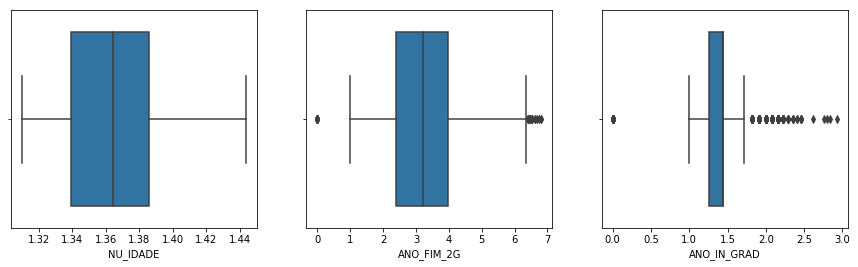

In [400]:
fig, eixos = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
sns.boxplot(x=df_dados_candidatos['NU_IDADE'], ax=eixos[0])
sns.boxplot(x=df_dados_candidatos['ANO_FIM_2G'], ax=eixos[1])
sns.boxplot(x=df_dados_candidatos['ANO_IN_GRAD'], ax=eixos[2])

Parece existir outliers em **ANO_FIM_2G** e **ANO_IN_GRAD**. Mas é um pouco complicado decidir se para estes campos realmente estes dados são considerado outlier. Porque é normal em avaliações como o Enade ter candidatos com diferentes perfis, que possam ter feito o ensino médio a muito tempo ou recente. Este tipo de comportamente para o campo ANO_FIM_2G pode ficar fora do limite de confiança da distribuição se apresentando como outlier, mas muitas vezes esta informação pode fazer sentido para o seu problema.

Um caso interessante que poderia considerar como outlier nestas distribuições, seria em **ANO_IN_GRAD**, candidatos que iniciaram a graduação há muito tempo atrás, por exemplo, em 1963 como existe no dataset, não conseguimos afirmar se é possível existir um candidato que tenha começado a graduação há mais de 50 anos atrás, e possa prestar o Enade no ano de 2014. Talvez esse valor é considerado outlier para o problema, mas cabe uma investigação a mais sobre o problema.

#### IQR

In [410]:
q75, q25 = np.percentile(df_dados_candidatos['ANO_FIM_2G'], [75 ,25])
iqr = q75 - q25
min_ano_fim_2g = q25 - (iqr*1.5)
max_ano_fim_2g = q75 + (iqr*1.5)

q75, q25 = np.percentile(df_dados_candidatos['ANO_IN_GRAD'], [75 ,25])
iqr = q75 - q25
min_ano_in_grad = q25 - (iqr*1.5)
max_ano_in_grad = q75 + (iqr*1.5)

print("ANO_FIM_2G", min_ano_fim_2g, max_ano_fim_2g)
print("ANO_IN_GRAD", min_ano_in_grad, max_ano_in_grad)

ANO_FIM_2G 0.016748442555664766 6.362878299869131
ANO_IN_GRAD 0.9864282692760705 1.7157423509262109


#### Outliers em ANO_FIM_2G

In [427]:
outliers_ano_fim_2g = df_dados_candidatos[ (df_dados_candidatos['ANO_FIM_2G'] > max_ano_fim_2g) | 
                    (df_dados_candidatos['ANO_FIM_2G'] < min_ano_fim_2g) ].index

df["ANO_FIM_2G"].loc[outliers_ano_fim_2g].describe()

count      38.000000
mean     1983.315789
std        22.472933
min      1963.000000
25%      1968.000000
50%      1969.000000
75%      2014.000000
max      2014.000000
Name: ANO_FIM_2G, dtype: float64

#### Outliers em ANO_IN_GRAD

In [428]:
outliers_ano_in_grad = df_dados_candidatos[ (df_dados_candidatos['ANO_IN_GRAD'] > max_ano_in_grad) |
                    (df_dados_candidatos['ANO_IN_GRAD'] < min_ano_in_grad) ].index

df['ANO_IN_GRAD'].loc[outliers_ano_in_grad].describe()

count    1871.000000
mean     2010.560663
std         3.818395
min      1989.000000
25%      2007.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: ANO_IN_GRAD, dtype: float64

Entre os 1871 classificados como outliers pelo IQR, poderíamos considerar que os estudantes que tenham iniciado a graduação até 2000 estão aptos para realizar o ENADE. Pois segundo o INEP (http://inep.gov.br/perguntas-frequentes4) a primeira avaliação do ENADE aconteceu em 2004 e para realizar a avaliação precisa ter pelo menos 25%, 50% e 75% do curso completo em alguns casos para está apto a realizar o exame. 

Antes de 2004 não houve registro de edições anteriores. Portanto um estudante que tenha começado a estudar em 1989, por exemplo, não participou de nenhuma edição do ENADE. Com isso podemos remover estes candidatos considerando como outliers para a base.

In [441]:
df_outlier_ano_in_grad = df.loc[outliers_ano_in_grad]
df_outlier_ano_in_grad = df_outlier_ano_in_grad[df_outlier_ano_in_grad['ANO_IN_GRAD'] < 2000]
df_outlier_ano_in_grad['ANO_IN_GRAD'].describe()

count      10.000000
mean     1995.600000
std         3.977716
min      1989.000000
25%      1992.250000
50%      1997.500000
75%      1999.000000
max      1999.000000
Name: ANO_IN_GRAD, dtype: float64

#### Remover candidatos com ANO_IN_GRAD < 2000

In [469]:
df_questionarios.drop(df_outlier_ano_in_grad.index, axis=0, inplace=True)
df_ies.drop(df_outlier_ano_in_grad.index, axis=0, inplace=True)
df_dados_candidatos.drop(df_outlier_ano_in_grad.index, axis=0, inplace=True)
Y.drop(df_outlier_ano_in_grad.index, axis=0, inplace=True)
print("Linhas de ANO_IN_GRAD com valor < 2000 removido")

Linhas de ANO_IN_GRAD com valor < 2000 removido


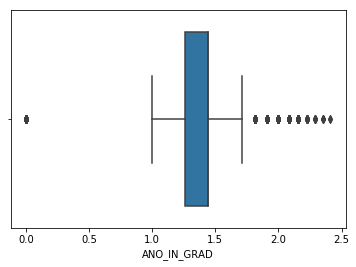

In [446]:
sns.boxplot(x=df_dados_candidatos['ANO_IN_GRAD'])

A distribuição parece ter diminiuido razoavelmente o número de outliers em relação a distribuição anterior mostrada. Portanto, agora cabe avaliar na seção de experimentos se esta remoção irá surtir efeito para os modelos.

### Classe

#### Binarizar o valor da classe para permitir classificação binária

Conforme enunciado, se um aluno tirar nota geral maior que 50, ele é aprovado, em caso contrário ele é reprovado. Seguindo essa lógica, transformamos o campo NT_GER em um campo binário, que será 1, caso a nota for maior que 50, e 0, em caso contrário.

- 1 - Aprovado (>50)
- 0 - Não aprovado (<=50)

In [470]:
y_binario = Y.apply( lambda x : x > 50 ).astype(int)

In [471]:
y_binario.head()

0    1
1    1
2    1
3    1
4    1
Name: NT_GER, dtype: int32

## Modelo de previsão

Nesta seção montaremos o conjunto de treino e teste separando as características em X e a classe em Y. Ao final executaremos os experimentos catalogando os resultando na seção dos resultados.

#### Características (X) e Classe (Y)

Com a lista de colunas criamos X, contendo os valores destas. E, y contendo os valores do campo de nota geral binarizado.

In [472]:
X = pd.concat([df_dados_candidatos, df_ies, df_questionarios], axis=1)
y = y_binario # Rotulo para identificar se o candidato foi aprovado
print("Características:", len(X.keys()))

Características: 565


#### Dividir em treino e teste

Agora criamos as bases de treino e teste, com a de teste ficando com 10% do total de instâncias da entrada.

In [473]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)
print('Dataset dividido em treino e teste')

Dataset dividido em treino e teste


## Experimento 1

Esse experimento teve o objetivo de comparar o desempenho da Random Forest (RF) e a Nede Reural (RN) diante da variação do número de atributos e configurações para os modelos.

Foram considerados como atributos para o experimento:

<table>
    <head>
        <tr>
            <td><b>Dados</b></td>
            <td><b>Utilizado</b></td>
            <td><b>Removido</b></td>
        </tr>
    </head>
    <tr>
        <td>Candidatos</td>
        <td>NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD, IN_MATUT, IN_VESPER, IN_NOTURNO</td>
        <td>ID_STATUS</td>
    </tr>
    <tr>
        <td>IES</td>
        <td>CO_CATEGAD, CO_ORGACAD, CO_UF_CURSO</td>
        <td>CO_IES, CO_CURSO, CO_GRUPO e CO_REGIAO_CURSO</td>
    </tr>
    <tr>
        <td>Questionários</td>
        <td>
            QE_I01, QE_I02, QE_I03,...,QE_I68<br>
        </td>
        <td>NT_INST</td>
    </tr>
</table>

O campo **NT_INST** não foi utilizado nestes experimentos porque desejamos testar nessa fase se os modelos aprenderão sobre os questionários QE_I27,.., QE_I68 relativos a avaliação do curso dada pelos candidatos. Portanto, nesta fase removemos o NT_INST para testar somente com as respostas brutas dos questionários

### Atributos 

Cada experimento foi formatado da seguinte maneira:
<table>
    <head>
        <tr>
            <td><b>Caso</b></td>
            <td><b>Normalização</b></td>
            <td><b>Suavização</b></td>
            <td><b>Categorização</b></td>
            <td><b>One-Hot-Econder</b></td>
            <td><b>Atributos</b></td>
        </tr>
    </head>
    <tr>
        <td>#C1</td>
        <td>
            NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD
        </td>
        <td></td>
        <td>
            CO_CATEGAD, CO_ORGACAD, CO_UF_CURSO<br>
            QE_I01, QE_I02, QE_I03,...,QE_I68<br>
            TP_SEXO
        </td>
        <td></td>
        <td>78</td>
    </tr>
    <tr>
        <td>#C2</td>
        <td>
            NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD
        </td>
        <td>
            NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD
        </td>
        <td>
            CO_CATEGAD, CO_ORGACAD, CO_UF_CURSO<br>
            QE_I01, QE_I02, QE_I03,...,QE_I68<br>
            TP_SEXO
        </td>
        <td>CO_CATEGAD, CO_ORGACAD, CO_UF_CURSO</td>
        <td>86</td>
    </tr>
    <tr>
        <td>#C3</td>
        <td>
            NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD
        </td>
        <td>
            NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD
        </td>
        <td>
            CO_CATEGAD, CO_ORGACAD, CO_UF_CURSO<br>
            QE_I01, QE_I02, QE_I03,...,QE_I68<br>
            TP_SEXO
        </td>
        <td>
            CO_CATEGAD, CO_ORGACAD, CO_UF_CURSO<br>
            QE_I01, QE_I02, QE_I03,...,QE_I68
        </td>
        <td>563</td>
    </tr>
</table>

Os 3 casos representam experimentos diferentes considerando o **número de atributos** e o **tipo de representação** utilizado. Para cada caso gerou-se 3 experimentos diferentes para o modelo da RF e RN, considerando configurações diferentes. No total temos **9 experimentos**, 3 para cada 1 caso.  

Cada modelo foi treinado com os seguintes parâmetros e configurações:

**Random Forest: configurações**

<table>
    <head>
        <tr>
            <td><b>Experimento</b></td>
            <td><b>Caso</b></td>
            <td><b>Estimator</b></td>
            <td><b>Random_state</b></td>
        </tr>
    </head>
    <tr>
        <td>#1</td>
        <td>#C1</td>
        <td>10</td>
        <td>0</td>
    </tr>
    <tr>
        <td>#2</td>
        <td>#C1</td>
        <td>50</td>
        <td>0</td>
    </tr>
    <tr>
        <td>#3</td>
        <td>#C1</td>
        <td>250</td>
        <td>0</td>
    </tr>
    <tr>
        <td>#4</td>
        <td>#C2</td>
        <td>300</td>
        <td>0</td>
    </tr>
    <tr>
        <td>#5</td>
        <td>#C2</td>
        <td>500</td>
        <td>0</td>
    </tr>
    <tr>
        <td>#6</td>
        <td>#C2</td>
        <td>800</td>
        <td>0</td>
    </tr>
    <tr>
        <td>#7</td>
        <td>#C3</td>
        <td>1000</td>
        <td>0</td>
    </tr>
    <tr>
        <td>#8</td>
        <td>#C3</td>
        <td>1010</td>
        <td>0</td>
    </tr>
    <tr>
        <td>#9</td>
        <td>#C3</td>
        <td>1012</td>
        <td>0</td>
    </tr>
</table>

A partir do experimento #7 o valor 1000 para o parâmetro **estimator** afetou a velocidade da RF por causa da alta quantidade de árvores na floresta. Portanto,  em relação aos experimentos anteriores a partir do #7 foram adicionadas poucas árvores por motivos de desempenho.

**Rede Neural: configurações**

<table>
    <head>
        <tr>
            <td><b>Experimento</b></td>
            <td><b>Caso</b></td>
            <td><b>Época</b></td>
            <td><b>Patience</b>
            <td><b>Random_state</b></td>
            <td><b>Camadas (Ocultas)</b></td>
            <td><b>Normalização em Batch</b></td>
            <td><b>Neurônios/Camada</b></td>
            <td><b>Ativação</b></td>
            <td><b>Dropout</b></td>
        </tr>
    </head>
    <tr>
        <td>#1</td>
        <td>#C1</td>
        <td>10</td>
        <td>5</td>
        <td>0</td>
        <td>2</td>
        <td>sim</td>
        <td>10</td>
        <td>sigmoid</td>
        <td>0.5</td>
    </tr>
    <tr>
        <td>#2</td>
        <td>#C1</td>
        <td>50</td>
        <td>10</td>
        <td>0</td>
        <td>2</td>
        <td>sim</td>
        <td>10</td>
        <td>sigmoid</td>
        <td>0.5</td>
    </tr>
    <tr>
        <td>#3</td>
        <td>#C1</td>
        <td>250</td>
        <td>15</td>
        <td>0</td>
        <td>2</td>
        <td>sim</td>
        <td>10</td>
        <td>sigmoid</td>
        <td>0.5</td>
    </tr>
    <tr>
        <td>#4</td>
        <td>#C2</td>
        <td>500</td>
        <td>15</td>
        <td>0</td>
        <td>2</td>
        <td>sim</td>
        <td>10</td>
        <td>sigmoid</td>
        <td>0.5</td>
    </tr>
    <tr>
        <td>#5</td>
        <td>#C2</td>
        <td>800</td>
        <td>20</td>
        <td>0</td>
        <td>2</td>
        <td>sim</td>
        <td>10</td>
        <td>sigmoid</td>
        <td>0.5</td>
    </tr>
    <tr>
        <td>#6</td>
        <td>#C2</td>
        <td>1000</td>
        <td>20</td>
        <td>0</td>
        <td>2</td>
        <td>sim</td>
        <td>10</td>
        <td>sigmoid</td>
        <td>0.5</td>
    </tr>
    <tr>
        <td>#7</td>
        <td>#C3</td>
        <td>1500</td>
        <td>25</td>
        <td>0</td>
        <td>2</td>
        <td>sim</td>
        <td>10</td>
        <td>sigmoid</td>
        <td>0.5</td>
    </tr>
    <tr>
        <td>#8</td>
        <td>#C3</td>
        <td>1500</td>
        <td>30</td>
        <td>0</td>
        <td>2</td>
        <td>sim</td>
        <td>10</td>
        <td>sigmoid</td>
        <td>0.5</td>
    </tr>
    <tr>
        <td>#9</td>
        <td>#C3</td>
        <td>1500</td>
        <td>35</td>
        <td>0</td>
        <td>2</td>
        <td>sim</td>
        <td>10</td>
        <td>sigmoid</td>
        <td>0.5</td>
    </tr>
</table>

A partir do experimento #3 a rede neural já estava econtrando um bom modelo com apenas 150-300 épocas. Portanto, aumentar o número de épocas não surtiu muito efeito ao modelo. Mas testamos outras configurações de **épocas** e **patience** para verificar se o modelo realmente encontrava um bom resultado com poucas épocas. 

### Random Forest (RF)

Nessa seção aplicaremos o modelo Random Forest paras previsões. Abaixo, definimos o classificador e montamos a floresta.

In [360]:
rf_model = get_random_forest_model(X_train, y_train, n_estimators=1012, random_state=0)

In [361]:
evaluate("Random Forest", rf_model, X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1012, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Estimating AUCROC, acc
ROC value: 68.03%
Acc: 68.14%
CMatrix: 
[[1406  555]
 [ 660 1192]]


In [362]:
attrs = list(X.columns.values)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    if importances[indices[f]] > 0:
        #print("%d. %f -- %s" % (f + 1, importances[indices[f]], attrs[indices[f]]))
        print("%s" % (attrs[indices[f]]))

Feature ranking:
ANO_FIM_2G
NU_IDADE
ANO_IN_GRAD
QE_I08_0
QE_I11_2
QE_I11_1
QE_I11_0
QE_I23_1
QE_I26_2
QE_I26_6


### Rede Neural (RN)

Nessa seção montaremos e aplicaremos as redes neurais para realizar a classificação.

#### Simples + Normalização em Batch + Droupout

Train on 27446 samples, validate on 6862 samples
Epoch 1/1500
 - 11s - loss: 0.7199 - val_loss: 0.6886
Epoch 2/1500
 - 3s - loss: 0.6944 - val_loss: 0.6893
Epoch 3/1500
 - 3s - loss: 0.6916 - val_loss: 0.6894
Epoch 4/1500
 - 3s - loss: 0.6908 - val_loss: 0.6887
Epoch 5/1500
 - 3s - loss: 0.6913 - val_loss: 0.6884
Epoch 6/1500
 - 3s - loss: 0.6901 - val_loss: 0.6869
Epoch 7/1500
 - 3s - loss: 0.6903 - val_loss: 0.6863
Epoch 8/1500
 - 3s - loss: 0.6897 - val_loss: 0.6854
Epoch 9/1500
 - 3s - loss: 0.6891 - val_loss: 0.6838
Epoch 10/1500
 - 3s - loss: 0.6878 - val_loss: 0.6815
Epoch 11/1500
 - 3s - loss: 0.6868 - val_loss: 0.6795
Epoch 12/1500
 - 3s - loss: 0.6867 - val_loss: 0.6781
Epoch 13/1500
 - 3s - loss: 0.6842 - val_loss: 0.6741
Epoch 14/1500
 - 3s - loss: 0.6856 - val_loss: 0.6733
Epoch 15/1500
 - 3s - loss: 0.6820 - val_loss: 0.6699
Epoch 16/1500
 - 3s - loss: 0.6800 - val_loss: 0.6656
Epoch 17/1500
 - 3s - loss: 0.6798 - val_loss: 0.6635
Epoch 18/1500
 - 3s - loss: 0.6758 - val_

 - 3s - loss: 0.6124 - val_loss: 0.5925
Epoch 152/1500
 - 3s - loss: 0.6093 - val_loss: 0.5919
Epoch 153/1500
 - 3s - loss: 0.6100 - val_loss: 0.5924
Epoch 154/1500
 - 3s - loss: 0.6108 - val_loss: 0.5923
Epoch 155/1500
 - 3s - loss: 0.6116 - val_loss: 0.5921
Epoch 156/1500
 - 3s - loss: 0.6099 - val_loss: 0.5917
Epoch 157/1500
 - 3s - loss: 0.6104 - val_loss: 0.5920
Epoch 158/1500
 - 3s - loss: 0.6125 - val_loss: 0.5926
Epoch 159/1500
 - 3s - loss: 0.6095 - val_loss: 0.5917
Epoch 160/1500
 - 3s - loss: 0.6104 - val_loss: 0.5919
Epoch 161/1500
 - 3s - loss: 0.6116 - val_loss: 0.5927
Epoch 162/1500
 - 3s - loss: 0.6086 - val_loss: 0.5918
Epoch 163/1500
 - 3s - loss: 0.6106 - val_loss: 0.5920
Epoch 164/1500
 - 3s - loss: 0.6096 - val_loss: 0.5918
Epoch 165/1500
 - 3s - loss: 0.6091 - val_loss: 0.5918
Epoch 166/1500
 - 3s - loss: 0.6074 - val_loss: 0.5919
Epoch 167/1500
 - 3s - loss: 0.6098 - val_loss: 0.5923
Epoch 168/1500
 - 3s - loss: 0.6079 - val_loss: 0.5921
Epoch 169/1500
 - 3s - lo

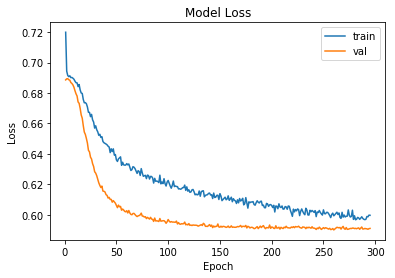


Estimating AUCROC, acc
ROC value: 74.72%
Acc: 68.14
CMatrix: 
[[1364  597]
 [ 618 1234]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 563)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 10)                5640      
_________________________________________________________________
batch_normalization_54 (Batc (None, 10)                40        
_________________________________________________________________
activation_76 (Activation)   (None, 10)                0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 10)                110       
____________________________________________________

In [363]:
def get_model(X_input_size):
    '''
        get_model cria um modelo de rede neural  
        X_input_size: número de atributos em X
    '''
    input_data = Input(name='input', shape=(X_input_size,), dtype='float32')
    
    x = input_data
    x = Dense(units = 10)(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(units = 10)(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(units = 1)(x)
    y_pred = Activation('sigmoid')(x)
    
    model = Model(inputs=input_data, outputs=y_pred)
    
    # modelo será treinado com otimizador SGD -- vc pode trocar o otimizador
    optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
    
    # função de custo usada é a entropia cruzada
    model.compile(loss='binary_crossentropy', optimizer = optimizer) 

    return model

model = get_model(len(X_train.keys()))
m = train_model(model, X_train, X_test, y_train, y_test, 
                bsize = 200, n_epochs = 1500, val_proportion = 0.2, patience = 35)

# exibe arquitetura e número de parâmetros no modelo
m.summary()

Na **seção de resultados** foi armazenado todos os valores.

## Experimento 2

Nessa seção montaremos variações da **rede neural** utilizando uma outra maneira de criar a arquitetura através da classe **Sequential** do Keras.

#### Atributos

<table>
    <head>
        <tr>
            <td><b>Normalização</b></td>
            <td><b>Suavização</b></td>
            <td><b>Categorização</b></td>
            <td><b>One-Hot-Econder</b></td>
            <td><b>Atributos</b></td>
        </tr>
    </head>
    <tr>
        <td>
            NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD
        </td>
        <td>
            NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD
        </td>
        <td>
            CO_CATEGAD, CO_ORGACAD, CO_UF_CURSO<br>
            QE_I01, QE_I02, QE_I03,...,QE_I68<br>
            TP_SEXO
        </td>
        <td>
            CO_CATEGAD, CO_ORGACAD, CO_UF_CURSO<br>
            QE_I01, QE_I02, QE_I03,...,QE_I68
        </td>
        <td>563</td>
    </tr>
</table>

### Rede Neural Simples

Aqui, definimos uma rede neural simples com duas camadas ocultas, além de realizar as chamadas das funções previamente definidas para realizar sua execução e impressão dos dados obtidos para análise.

In [369]:
print("Atributos:", len(X_train.keys()))

Atributos: 563


Train on 27446 samples, validate on 6862 samples
Epoch 1/1000
 - 9s - loss: 0.6927 - acc: 0.5143 - val_loss: 0.6926 - val_acc: 0.5066
Epoch 2/1000
 - 3s - loss: 0.6926 - acc: 0.5128 - val_loss: 0.6932 - val_acc: 0.5067
Epoch 3/1000
 - 3s - loss: 0.6920 - acc: 0.5164 - val_loss: 0.6921 - val_acc: 0.5067
Epoch 4/1000
 - 3s - loss: 0.6918 - acc: 0.5174 - val_loss: 0.6920 - val_acc: 0.5067
Epoch 5/1000
 - 3s - loss: 0.6914 - acc: 0.5253 - val_loss: 0.6912 - val_acc: 0.5695
Epoch 6/1000
 - 3s - loss: 0.6910 - acc: 0.5309 - val_loss: 0.6919 - val_acc: 0.5067
Epoch 7/1000
 - 3s - loss: 0.6904 - acc: 0.5344 - val_loss: 0.6903 - val_acc: 0.5162
Epoch 8/1000
 - 3s - loss: 0.6900 - acc: 0.5360 - val_loss: 0.6897 - val_acc: 0.5162
Epoch 9/1000
 - 3s - loss: 0.6892 - acc: 0.5485 - val_loss: 0.6889 - val_acc: 0.5175
Epoch 10/1000
 - 3s - loss: 0.6884 - acc: 0.5416 - val_loss: 0.6876 - val_acc: 0.5568
Epoch 11/1000
 - 3s - loss: 0.6870 - acc: 0.5576 - val_loss: 0.6877 - val_acc: 0.5163
Epoch 12/1000


Epoch 96/1000
 - 3s - loss: 0.5727 - acc: 0.6981 - val_loss: 0.5875 - val_acc: 0.6878
Epoch 97/1000
 - 3s - loss: 0.5724 - acc: 0.7000 - val_loss: 0.5842 - val_acc: 0.6927
Epoch 98/1000
 - 3s - loss: 0.5724 - acc: 0.6981 - val_loss: 0.5838 - val_acc: 0.6896
Epoch 99/1000
 - 3s - loss: 0.5721 - acc: 0.6988 - val_loss: 0.5839 - val_acc: 0.6909
Epoch 100/1000
 - 3s - loss: 0.5717 - acc: 0.6984 - val_loss: 0.5840 - val_acc: 0.6909
Epoch 101/1000
 - 3s - loss: 0.5714 - acc: 0.7003 - val_loss: 0.5841 - val_acc: 0.6906
Epoch 102/1000
 - 3s - loss: 0.5712 - acc: 0.7005 - val_loss: 0.5849 - val_acc: 0.6953
Epoch 103/1000
 - 3s - loss: 0.5711 - acc: 0.7005 - val_loss: 0.5838 - val_acc: 0.6916
Epoch 104/1000
 - 3s - loss: 0.5708 - acc: 0.6984 - val_loss: 0.5839 - val_acc: 0.6927
Epoch 105/1000
 - 3s - loss: 0.5714 - acc: 0.7007 - val_loss: 0.5853 - val_acc: 0.6943
Epoch 106/1000
 - 3s - loss: 0.5707 - acc: 0.7007 - val_loss: 0.5880 - val_acc: 0.6932
Epoch 107/1000
 - 3s - loss: 0.5700 - acc: 0.70

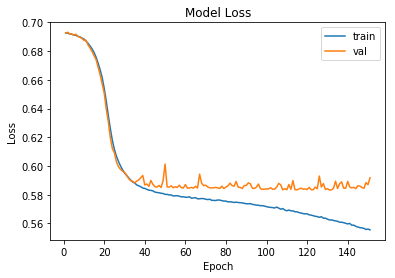


Estimating AUCROC, acc
ROC value: 75.15%
Acc: 68.42
CMatrix: 
[[1517  444]
 [ 760 1092]]


In [370]:
model = Sequential()
# Camada de Entrada
model.add(Dense(50, activation = "sigmoid",input_shape=(len(X_train.keys()), )))
# Camadas Ocultas
model.add(Dense(50, activation = "sigmoid"))
model.add(Dense(50, activation = "sigmoid"))
# Camada de Saída
model.add(Dense(1, activation = "sigmoid"))


optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
# Compilando o Modelo
model.compile(
 #optimizer = "adam",
 optimizer = optimizer,
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

train_model(model, X_train, X_test, y_train, y_test)

Resultado muito bom avaliando a matriz de confusão, pois as classes estão balanceadas em relação ao erro intraclasse. 

### Rede Neural com Normalização em Batch

Aqui, definimos uma rede neural com normalização em Batch com duas camadas ocultas, além de realizar as chamadas das funções previamente definidas para realizar sua execução e impressão dos dados obtidos para análise. A normalização é feita logo após a inserção das camadas ocultas com modo de ativação **relu**, por apresentarem melhores resultados, segundo artigos científicos.

In [371]:
print("Atributos:", len(X_train.keys()))

Atributos: 563


Train on 27446 samples, validate on 6862 samples
Epoch 1/1000
 - 13s - loss: 1.4704 - acc: 0.5216 - val_loss: 0.6739 - val_acc: 0.5904
Epoch 2/1000
 - 4s - loss: 0.6654 - acc: 0.6042 - val_loss: 0.6543 - val_acc: 0.6218
Epoch 3/1000
 - 4s - loss: 0.6467 - acc: 0.6335 - val_loss: 0.6438 - val_acc: 0.6313
Epoch 4/1000
 - 4s - loss: 0.6286 - acc: 0.6584 - val_loss: 0.6520 - val_acc: 0.6106
Epoch 5/1000
 - 4s - loss: 0.6132 - acc: 0.6737 - val_loss: 0.6556 - val_acc: 0.6128
Epoch 6/1000
 - 4s - loss: 0.6042 - acc: 0.6816 - val_loss: 0.6100 - val_acc: 0.6740
Epoch 7/1000
 - 4s - loss: 0.5964 - acc: 0.6872 - val_loss: 0.6086 - val_acc: 0.6778
Epoch 8/1000
 - 4s - loss: 0.5908 - acc: 0.6908 - val_loss: 0.6009 - val_acc: 0.6823
Epoch 9/1000
 - 4s - loss: 0.5865 - acc: 0.6932 - val_loss: 0.5942 - val_acc: 0.6906
Epoch 10/1000
 - 4s - loss: 0.5832 - acc: 0.6975 - val_loss: 0.5983 - val_acc: 0.6858
Epoch 11/1000
 - 4s - loss: 0.5799 - acc: 0.6998 - val_loss: 0.5975 - val_acc: 0.6865
Epoch 12/1000

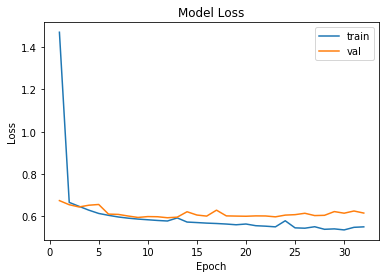


Estimating AUCROC, acc
ROC value: 73.00%
Acc: 66.80
CMatrix: 
[[1300  661]
 [ 605 1247]]


In [373]:
model = Sequential()
# Camada de Entrada
model.add(Dense(50, activation = "sigmoid", input_shape=(len(X_train.keys()), )))
# Camadas Ocultas
model.add(Dense(50, activation = "relu"))
model.add(BatchNormalization())
model.add(Dense(50, activation = "relu"))
model.add(BatchNormalization())
# Camada de Saída
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())

optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
# Compilando o Modelo
model.compile(
 #optimizer = "adam",
 optimizer = optimizer,
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

train_model(model, X_train, X_test, y_train, y_test)

Resultado muito mais rápido que a rede neural simples realizado no experimento anterior. Esta rapidez possivelmente é por conta da função de ativação Relu, que entrega na maioria das vezes mais gradientes válidos do que a função sigmoid. Portanto no meio do processo isso ajuda a rede a não deixar os neurônios "morrerem" e continuarem com gradientes válidos minimizando a função de perda. 

A acurácia desta arquitetura ficou bem próxima a 68% do melhor resultado e ROC value próximo ao valor 75% do melhor resultado computado na **seção de experimento 1**, utilizando apenas normalização em batch sem droupout com 50 neurônios 2 camadas ocultas e função de ativação relu.

### Rede Neural com Dropout

Aqui, definimos uma rede neural com dropout, sendo eles feitos como camadas ocultas com valores distintos, **nunca acima de 50%**. Além de realizar as chamadas das funções previamente definidas para realizar sua execução e impressão dos dados obtidos para análise.

In [374]:
print("Atributos:", len(X_train.keys()))

Atributos: 563


Train on 27446 samples, validate on 6862 samples
Epoch 1/1000
 - 10s - loss: 0.6946 - acc: 0.5075 - val_loss: 0.6948 - val_acc: 0.5067
Epoch 2/1000
 - 3s - loss: 0.6940 - acc: 0.5085 - val_loss: 0.6928 - val_acc: 0.5068
Epoch 3/1000
 - 3s - loss: 0.6934 - acc: 0.5115 - val_loss: 0.6941 - val_acc: 0.5067
Epoch 4/1000
 - 3s - loss: 0.6934 - acc: 0.5124 - val_loss: 0.6926 - val_acc: 0.5067
Epoch 5/1000
 - 3s - loss: 0.6934 - acc: 0.5115 - val_loss: 0.6933 - val_acc: 0.5067
Epoch 6/1000
 - 3s - loss: 0.6930 - acc: 0.5123 - val_loss: 0.6924 - val_acc: 0.5067
Epoch 7/1000
 - 3s - loss: 0.6928 - acc: 0.5167 - val_loss: 0.6925 - val_acc: 0.5067
Epoch 8/1000
 - 3s - loss: 0.6928 - acc: 0.5160 - val_loss: 0.6921 - val_acc: 0.5067
Epoch 9/1000
 - 3s - loss: 0.6927 - acc: 0.5157 - val_loss: 0.6923 - val_acc: 0.4933
Epoch 10/1000
 - 3s - loss: 0.6925 - acc: 0.5154 - val_loss: 0.6922 - val_acc: 0.5067
Epoch 11/1000
 - 3s - loss: 0.6921 - acc: 0.5190 - val_loss: 0.6916 - val_acc: 0.5067
Epoch 12/1000

Epoch 96/1000
 - 3s - loss: 0.6028 - acc: 0.6704 - val_loss: 0.5912 - val_acc: 0.6868
Epoch 97/1000
 - 3s - loss: 0.6036 - acc: 0.6723 - val_loss: 0.5915 - val_acc: 0.6870
Epoch 98/1000
 - 3s - loss: 0.6033 - acc: 0.6749 - val_loss: 0.5904 - val_acc: 0.6892
Epoch 99/1000
 - 3s - loss: 0.6041 - acc: 0.6729 - val_loss: 0.5897 - val_acc: 0.6865
Epoch 100/1000
 - 3s - loss: 0.6000 - acc: 0.6758 - val_loss: 0.5896 - val_acc: 0.6864
Epoch 101/1000
 - 3s - loss: 0.6010 - acc: 0.6757 - val_loss: 0.5899 - val_acc: 0.6884
Epoch 102/1000
 - 3s - loss: 0.6019 - acc: 0.6760 - val_loss: 0.5893 - val_acc: 0.6883
Epoch 103/1000
 - 3s - loss: 0.6025 - acc: 0.6768 - val_loss: 0.5893 - val_acc: 0.6894
Epoch 104/1000
 - 3s - loss: 0.6000 - acc: 0.6756 - val_loss: 0.5906 - val_acc: 0.6851
Epoch 105/1000
 - 3s - loss: 0.6006 - acc: 0.6751 - val_loss: 0.5913 - val_acc: 0.6865
Epoch 106/1000
 - 3s - loss: 0.5993 - acc: 0.6776 - val_loss: 0.5887 - val_acc: 0.6868
Epoch 107/1000
 - 3s - loss: 0.6002 - acc: 0.67

Epoch 191/1000
 - 3s - loss: 0.5883 - acc: 0.6850 - val_loss: 0.5848 - val_acc: 0.6938
Epoch 192/1000
 - 3s - loss: 0.5896 - acc: 0.6846 - val_loss: 0.5855 - val_acc: 0.6916
Epoch 193/1000
 - 3s - loss: 0.5878 - acc: 0.6871 - val_loss: 0.5844 - val_acc: 0.6931
Epoch 194/1000
 - 3s - loss: 0.5892 - acc: 0.6835 - val_loss: 0.5842 - val_acc: 0.6945
Epoch 195/1000
 - 3s - loss: 0.5896 - acc: 0.6849 - val_loss: 0.5854 - val_acc: 0.6911
Epoch 196/1000
 - 3s - loss: 0.5891 - acc: 0.6886 - val_loss: 0.5847 - val_acc: 0.6940
Epoch 197/1000
 - 3s - loss: 0.5882 - acc: 0.6883 - val_loss: 0.5854 - val_acc: 0.6912
Epoch 198/1000
 - 3s - loss: 0.5898 - acc: 0.6855 - val_loss: 0.5847 - val_acc: 0.6943
Epoch 199/1000
 - 3s - loss: 0.5886 - acc: 0.6870 - val_loss: 0.5841 - val_acc: 0.6937
Epoch 200/1000
 - 3s - loss: 0.5884 - acc: 0.6839 - val_loss: 0.5851 - val_acc: 0.6918
Epoch 201/1000
 - 3s - loss: 0.5904 - acc: 0.6834 - val_loss: 0.5847 - val_acc: 0.6931
Epoch 202/1000
 - 3s - loss: 0.5876 - acc: 

 - 3s - loss: 0.5832 - acc: 0.6920 - val_loss: 0.5832 - val_acc: 0.6947
Epoch 286/1000
 - 3s - loss: 0.5824 - acc: 0.6888 - val_loss: 0.5826 - val_acc: 0.6924
Epoch 287/1000
 - 3s - loss: 0.5823 - acc: 0.6910 - val_loss: 0.5834 - val_acc: 0.6957
Epoch 288/1000
 - 3s - loss: 0.5824 - acc: 0.6890 - val_loss: 0.5830 - val_acc: 0.6947
Epoch 289/1000
 - 3s - loss: 0.5826 - acc: 0.6918 - val_loss: 0.5830 - val_acc: 0.6947
Epoch 290/1000
 - 3s - loss: 0.5815 - acc: 0.6927 - val_loss: 0.5841 - val_acc: 0.6954
Epoch 291/1000
 - 3s - loss: 0.5821 - acc: 0.6910 - val_loss: 0.5829 - val_acc: 0.6947
Epoch 292/1000
 - 3s - loss: 0.5832 - acc: 0.6932 - val_loss: 0.5824 - val_acc: 0.6928
Epoch 293/1000
 - 3s - loss: 0.5825 - acc: 0.6901 - val_loss: 0.5828 - val_acc: 0.6929
Epoch 294/1000
 - 3s - loss: 0.5804 - acc: 0.6919 - val_loss: 0.5822 - val_acc: 0.6935
Epoch 295/1000
 - 3s - loss: 0.5816 - acc: 0.6900 - val_loss: 0.5822 - val_acc: 0.6929
Epoch 296/1000
 - 3s - loss: 0.5816 - acc: 0.6900 - val_lo

Epoch 380/1000
 - 3s - loss: 0.5764 - acc: 0.6954 - val_loss: 0.5813 - val_acc: 0.6954
Epoch 381/1000
 - 3s - loss: 0.5756 - acc: 0.6978 - val_loss: 0.5814 - val_acc: 0.6944
Epoch 382/1000
 - 3s - loss: 0.5779 - acc: 0.6943 - val_loss: 0.5815 - val_acc: 0.6935
Epoch 383/1000
 - 3s - loss: 0.5777 - acc: 0.6964 - val_loss: 0.5819 - val_acc: 0.6953
Epoch 384/1000
 - 4s - loss: 0.5774 - acc: 0.6937 - val_loss: 0.5815 - val_acc: 0.6948
Epoch 385/1000
 - 3s - loss: 0.5766 - acc: 0.6952 - val_loss: 0.5818 - val_acc: 0.6948
Epoch 386/1000
 - 3s - loss: 0.5777 - acc: 0.6947 - val_loss: 0.5814 - val_acc: 0.6957
Epoch 387/1000
 - 3s - loss: 0.5769 - acc: 0.6946 - val_loss: 0.5822 - val_acc: 0.6940
Epoch 388/1000
 - 3s - loss: 0.5757 - acc: 0.6943 - val_loss: 0.5816 - val_acc: 0.6932
Epoch 389/1000
 - 3s - loss: 0.5766 - acc: 0.6950 - val_loss: 0.5817 - val_acc: 0.6934
Epoch 390/1000
 - 3s - loss: 0.5780 - acc: 0.6938 - val_loss: 0.5814 - val_acc: 0.6941
Epoch 391/1000
 - 3s - loss: 0.5786 - acc: 

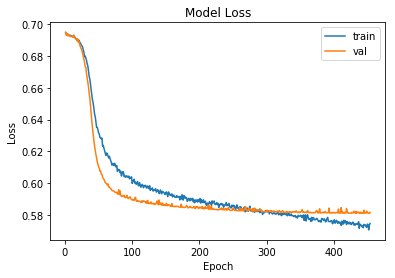


Estimating AUCROC, acc
ROC value: 75.59%
Acc: 68.69
CMatrix: 
[[1422  539]
 [ 655 1197]]


In [375]:
model = Sequential()
# Camada de Entrada
model.add(Dense(50, activation = "sigmoid",input_shape=(len(X_train.keys()), )))
# Camadas Ocultas
model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(50, activation = "sigmoid"))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(50, activation = "sigmoid"))
# Camada de Saída
model.add(Dense(1, activation = "sigmoid"))

optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
# Compilando o Modelo
model.compile(
 #optimizer = "adam",
 optimizer = optimizer,
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

train_model(model, X_train, X_test, y_train, y_test)

Resultado muito bom, parecido com o melhor resultado da **seção de experimento 1** com a diferença que aqui utilizamos apenas dropout sem normalização em batch e 50 neurônios em 2 camadas ocultas.

## Experimento 3

Nesta seção iremos testar a melhor arquitetura da RF e RN encontrada nos experimentos anteriores com novos atributos. Além de testar com a remoção de outliers da base. Com isso esperamos que tenhamos resultados melhores, e em seguida testaremos uma nova arquitetura da RN com 4 camadas. 

#### Atributos

<table>
    <head>
        <tr>
            <td><b>Adicionado</b></td>
            <td><b>Outlier removido</b></td>
            <td><b>Normalização</b></td>
            <td><b>Suavização</b></td>
            <td><b>Categorização</b></td>
            <td><b>One-Hot-Econder</b></td>
            <td><b>Atributos</b></td>
        </tr>
    </head>
    <tr>
        <td>
            <b>NT_INST</b><br>
            <b>QUOTISTA</b><br>
        </td>
        <td>
            ANO_IN_GRAD (20)
        </td>
        <td>
            NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD
        </td>
        <td>
            NU_IDADE, ANO_FIM_2G, ANO_IN_GRAD
        </td>
        <td>
            CO_CATEGAD, CO_ORGACAD, CO_UF_CURSO<br>
            QE_I01, QE_I02, QE_I03,...,QE_I68<br>
            TP_SEXO<br>
        </td>
        <td>
            CO_CATEGAD, CO_ORGACAD, CO_UF_CURSO<br>
            QE_I01, QE_I02, QE_I03,...,QE_I68
        </td>
        <td>565</td>
    </tr>
</table>

### Random Forest (RF)

Arquitetura do melhor resultado dos experimentos 1

In [474]:
rf_model = get_random_forest_model(X_train, y_train, n_estimators=300, random_state=0)

In [475]:
evaluate("Random Forest", rf_model, X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Estimating AUCROC, acc
ROC value: 68.09%
Acc: 68.26%
CMatrix: 
[[1438  537]
 [ 673 1164]]


Mesmo resultado encontrado nos experimentos 1. Então os atributos adicionados e a remoção dos outliers não tiveram um efeito impactante na RF. 

### Rede Neural com Normalização em Batch + Dropout

Arquitetura do melhor resultado dos experimentos 1

Train on 27439 samples, validate on 6860 samples
Epoch 1/1000
 - 16s - loss: 1.2169 - acc: 0.5189 - val_loss: 0.6901 - val_acc: 0.5529
Epoch 2/1000
 - 5s - loss: 0.6865 - acc: 0.5540 - val_loss: 0.6878 - val_acc: 0.5579
Epoch 3/1000
 - 4s - loss: 0.6863 - acc: 0.5556 - val_loss: 0.6861 - val_acc: 0.5627
Epoch 4/1000
 - 3s - loss: 0.6854 - acc: 0.5587 - val_loss: 0.6872 - val_acc: 0.5640
Epoch 5/1000
 - 3s - loss: 0.6847 - acc: 0.5625 - val_loss: 0.6835 - val_acc: 0.5665
Epoch 6/1000
 - 2s - loss: 0.6843 - acc: 0.5649 - val_loss: 0.6824 - val_acc: 0.5694
Epoch 7/1000
 - 2s - loss: 0.6829 - acc: 0.5669 - val_loss: 0.6835 - val_acc: 0.5722
Epoch 8/1000
 - 2s - loss: 0.6824 - acc: 0.5688 - val_loss: 0.6809 - val_acc: 0.5790
Epoch 9/1000
 - 2s - loss: 0.6788 - acc: 0.5778 - val_loss: 0.6739 - val_acc: 0.5945
Epoch 10/1000
 - 2s - loss: 0.6767 - acc: 0.5837 - val_loss: 0.6695 - val_acc: 0.6079
Epoch 11/1000
 - 2s - loss: 0.6719 - acc: 0.5941 - val_loss: 0.6579 - val_acc: 0.6265
Epoch 12/1000

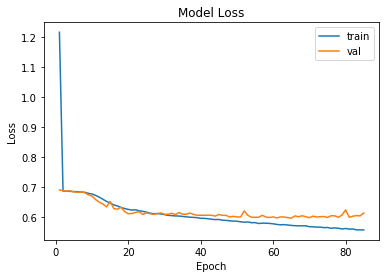


Estimating AUCROC, acc
ROC value: 75.39%
Acc: 68.81
CMatrix: 
[[1384  591]
 [ 598 1239]]


In [476]:
model = Sequential()
# Camada de Entrada
model.add(Dense(50, activation = "sigmoid", input_shape=(len(X_train.keys()), )))
# Camadas Ocultas
model.add(Dense(50, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5, noise_shape=None, seed=None))
# Camada de Saída
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())

optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
# Compilando o Modelo
model.compile(
 #optimizer = "adam",
 optimizer = optimizer,
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

train_model(model, X_train, X_test, y_train, y_test)

### Rede Neural com Normalização em Batch + Dropout + 4 camadas ocultas

Train on 27439 samples, validate on 6860 samples
Epoch 1/1000
 - 17s - loss: 1.2825 - acc: 0.4893 - val_loss: 0.6941 - val_acc: 0.4999
Epoch 2/1000
 - 6s - loss: 0.6935 - acc: 0.5111 - val_loss: 0.6951 - val_acc: 0.4999
Epoch 3/1000
 - 6s - loss: 0.6936 - acc: 0.5095 - val_loss: 0.6937 - val_acc: 0.4999
Epoch 4/1000
 - 6s - loss: 0.6936 - acc: 0.5106 - val_loss: 0.6926 - val_acc: 0.5155
Epoch 5/1000
 - 6s - loss: 0.6936 - acc: 0.5112 - val_loss: 0.6947 - val_acc: 0.4999
Epoch 6/1000
 - 6s - loss: 0.6930 - acc: 0.5156 - val_loss: 0.6927 - val_acc: 0.5026
Epoch 7/1000
 - 6s - loss: 0.6932 - acc: 0.5087 - val_loss: 0.6930 - val_acc: 0.4996
Epoch 8/1000
 - 6s - loss: 0.6933 - acc: 0.5128 - val_loss: 0.6940 - val_acc: 0.4999
Epoch 9/1000
 - 6s - loss: 0.6931 - acc: 0.5115 - val_loss: 0.6925 - val_acc: 0.5003
Epoch 10/1000
 - 6s - loss: 0.6928 - acc: 0.5155 - val_loss: 0.6952 - val_acc: 0.4999
Epoch 11/1000
 - 6s - loss: 0.6928 - acc: 0.5167 - val_loss: 0.6972 - val_acc: 0.4999
Epoch 12/1000

Epoch 96/1000
 - 6s - loss: 0.5771 - acc: 0.7124 - val_loss: 0.5913 - val_acc: 0.6965
Epoch 97/1000
 - 6s - loss: 0.5765 - acc: 0.7082 - val_loss: 0.6020 - val_acc: 0.6869
Epoch 98/1000
 - 6s - loss: 0.5738 - acc: 0.7130 - val_loss: 0.6030 - val_acc: 0.6930
Epoch 99/1000
 - 6s - loss: 0.5757 - acc: 0.7117 - val_loss: 0.5945 - val_acc: 0.6908
Epoch 100/1000
 - 6s - loss: 0.5715 - acc: 0.7158 - val_loss: 0.5883 - val_acc: 0.6956
Epoch 00100: early stopping


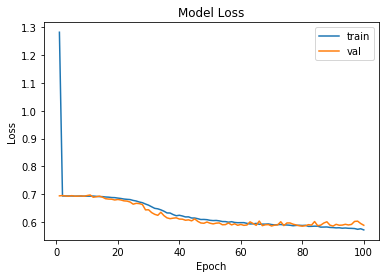


Estimating AUCROC, acc
ROC value: 75.86%
Acc: 69.33
CMatrix: 
[[1347  628]
 [ 541 1296]]


In [478]:
model = Sequential()
# Camada de Entrada
model.add(Dense(50, activation = "sigmoid", input_shape=(len(X_train.keys()), )))
# Camadas Ocultas
model.add(Dense(50, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5, noise_shape=None, seed=None))
# Camada de Saída
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())

optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
# Compilando o Modelo
model.compile(
 #optimizer = "adam",
 optimizer = optimizer,
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

train_model(model, X_train, X_test, y_train, y_test)

## Resultados

Todos experimentos foram feitos sob as mesmas condições considerando o número de instâncias no treino e teste e o mesmo número de atributos. Como avaliação utilizou-se a acurácia e a medida AUCROC no conjunto de validação (teste). Empiricamente foram setados os atributos para melhorar os resultados e testado diferentes modelos. 

Nos experimentos as siglas RF e RN significam:
- **RF** significa **Random Forest**
- **RN** significa **Rede Neural**

### Resultados do experimento 1

<table>
    <head>
        <tr>
            <td><b>Experimento</b></td>
            <td><b>Acurácia RF</b></td>
            <td><b>Acurácia RN</b></td>
            <td><b>AUCROC RF</b></td>
            <td><b>AUCROC RN</b></td>
            <td><b>Matriz de confusão RF</b></td>
            <td><b>Matriz de confusão RN</b></td>
            <td><b>Top 10 importância RF</b></td>
            <td><b>Parâmetros RN</b></td>
        </tr>
    </head>
    <tr>
        <td>#1</td>
        <td style="font-weight:bold">62.81%</td>
        <td>51.40%</td>
        <td style="font-weight:bold">62.52%</td>
        <td>58.07%</td>
        <td>
            [1425  536]<br>
            [ 882  970]
        </td>
        <td>
            [1953    8]<br>
            [1845    7]
        </td>
        <td style="text-align: right">
            QE_I08<br>
            NU_IDADE<br>
            ANO_FIM_2G<br>
            QE_I26<br>
            QE_I11<br>
            QE_I07<br>
            QE_I20<br>
            CO_CATEGAD<br>
            QE_I16<br>
            QE_I09
        </td>
        <td>
            Total params: 991<br>
            Trainable params: 951<br>
            Non-trainable params: 40
        </td>
    </tr>
    <tr>
        <td>#2</td>
        <td style="font-weight:bold">66.04%</td>
        <td>61.24%</td>
        <td>65.86%</td>
        <td style="font-weight:bold">66.22%</td>
        <td>
            [1416  545]<br>
            [ 750 1102]
        </td>
        <td>
            [1582  379]<br>
            [1099  753]
        </td>
        <td style="text-align: right">
            QE_I08<br>
            ANO_FIM_2G<br>
            NU_IDADE<br>
            QE_I11<br>
            QE_I26<br>
            QE_I07<br>
            QE_I20<br>
            QE_I25<br>
            QE_I16<br>
            QE_I09
        </td>
        <td>
            Total params: 991<br>
            Trainable params: 951<br>
            Non-trainable params: 40
        </td>
    </tr>
    <tr>
        <td>#3</td>
        <td style="font-weight:bold">68.06%</td>
        <td>64.54%</td>
        <td>67.43%</td>
        <td style="font-weight:bold">70.18%</td>
        <td>
            [1395  566]<br>
            [ 652 1200]
        </td>
        <td>
            [1432  529]<br>
            [ 823 1029]
        </td>
        <td style="text-align: right">
            QE_I08<br>
            NU_IDADE<br>
            ANO_FIM_2G<br>
            QE_I11<br>
            QE_I26<br>
            QE_I07<br>
            QE_I20<br>
            QE_I25<br>
            QE_I16<br>
            QE_I09
        </td>
        <td>
            Total params: 991<br>
            Trainable params: 951<br>
            Non-trainable params: 40
        </td>
    </tr>
    <tr>
        <td>#4</td>
        <td style="font-weight:bold">66.93%</td>
        <td>64.59%</td>
        <td>66.83%</td>
        <td style="font-weight:bold">70.73%</td>
        <td>
            [1381  580]<br>
            [ 681 1171]
        </td>
        <td>
            [1378  583]<br>
            [ 767 1085]
        </td>
        <td style="text-align: right">
            ANO_FIM_2G<br>
            NU_IDADE<br>
            QE_I08<br>
            QE_I11<br>
            QE_I26<br>
            QE_I07<br>
            QE_I20<br>
            QE_I25<br>
            QE_I09<br>
            QE_I22
        </td>
        <td>
            Total params: 1,071<br>
            Trainable params: 1,031<br>
            Non-trainable params: 40
        </td>
    </tr>
    <tr>
        <td>#5</td>
        <td style="font-weight:bold">67.66%</td>
        <td>64.36%</td>
        <td>67.57%</td>
        <td style="font-weight:bold">70.83%</td>
        <td>
            [1390  571]<br>
            [ 662 1190]
        </td>
        <td>
            [1383  578]<br>
            [ 781 1071]
        </td>
        <td style="text-align: right">
            ANO_FIM_2G<br>
            QE_I08<br>
            NU_IDADE<br>
            QE_I11<br>
            QE_I26<br>
            QE_I07<br>
            QE_I20<br>
            QE_I25<br>
            QE_I09<br>
            QE_I22
        </td>
        <td>
            Total params: 1,071<br>
            Trainable params: 1,031<br>
            Non-trainable params: 40
        </td>
    </tr>
    <tr>
        <td>#6</td>
        <td style="font-weight:bold">67.61%</td>
        <td>65.01%</td>
        <td>67.52%</td>
        <td style="font-weight:bold">70.79%</td>
        <td>
            [1385  576]<br>
            [ 659 1193]
        </td>
        <td>
            [1353  608]<br>
            [ 726 1126]
        </td>
        <td style="text-align: right">
            QE_I08<br>
            ANO_FIM_2G<br>
            NU_IDADE<br>
            QE_I11<br>
            QE_I26<br>
            QE_I07<br>
            QE_I20<br>
            QE_I25<br>
            QE_I09<br>
            QE_I22
        </td>
        <td>
            Total params: 1,071<br>
            Trainable params: 1,031<br>
            Non-trainable params: 40
        </td>
    </tr>
    <tr>
        <td>#7</td>
        <td style="font-weight:bold">68.24%</td>
        <td>67.77%</td>
        <td>68.14%</td>
        <td style="font-weight:bold">74.83%</td>
        <td>
            [1407  554]<br>
            [ 657 1195]
        </td>
        <td>
            [1402  559]<br>
            [ 670 1182]
        </td>
        <td style="text-align: right">
            ANO_FIM_2G<br>
            NU_IDADE<br>
            ANO_IN_GRAD<br>
            QE_I08_0<br>
            QE_I11_2<br>
            QE_I11_1<br>
            QE_I11_0<br>
            QE_I23_1<br>
            QE_I26_2<br>
            QE_I26_6<br>
        </td>
        <td>
            Total params: 5,841<br>
            Trainable params: 5,801<br>
            Non-trainable params: 40
        </td>
    </tr>
    <tr>
        <td>#8</td>
        <td style="font-weight:bold">68.19%</td>
        <td>67.85%</td>
        <td>68.08%</td>
        <td style="font-weight:bold">75.40%</td>
        <td>
            [1409  552]<br>
            [ 661 1191]
        </td>
        <td>
            [1423  538]<br>
            [ 688 1164]
        </td>
        <td style="text-align: right">
            ANO_FIM_2G<br>
            NU_IDADE<br>
            ANO_IN_GRAD<br>
            QE_I08_0<br>
            QE_I11_2<br>
            QE_I11_1<br>
            QE_I11_0<br>
            QE_I23_1<br>
            QE_I26_2<br>
            QE_I26_6
        </td>
        <td>
            Total params: 5,841<br>
            Trainable params: 5,801<br>
            Non-trainable params: 40
        </td>
    </tr>
    <tr>
        <td>#9</td>
        <td>68.14%</td>
        <td style="font-weight:bold">68.14%</td>
        <td>68.03%</td>
        <td style="font-weight:bold">74.72%</td>
        <td>
            [1406  555]<br>
            [ 660 1192]
        </td>
        <td>
            [1364  597]<br>
            [ 618 1234]
        </td>
        <td style="text-align: right">
            ANO_FIM_2G<br>
            NU_IDADE<br>
            ANO_IN_GRAD<br>
            QE_I08_0<br>
            QE_I11_2<br>
            QE_I11_1<br>
            QE_I11_0<br>
            QE_I23_1<br>
            QE_I26_2<br>
            QE_I26_6
        </td>
        <td>
            Total params: 5,841<br>
            Trainable params: 5,801<br>
            Non-trainable params: 40
        </td>
    </tr>
</table>

#### Comparativo de cada experimento em relação a acurácia e AUCROC

Todos os valores foram extraídos da tabela acima.

Text(0.5,1,'AUCROC RF vs RN')

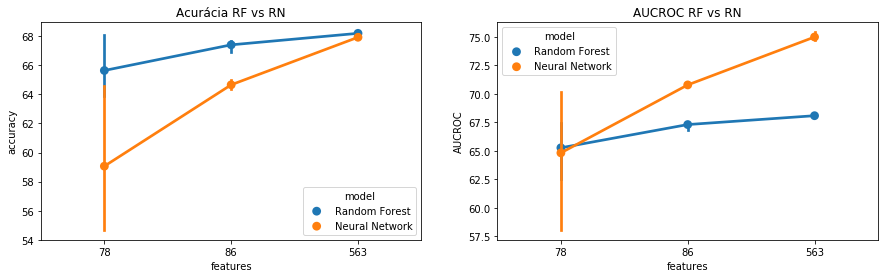

In [368]:
results_acc = [ 
        #C1
        { 'accuracy' : 62.81, 'features' : 78, 'model' : 'Random Forest' },
        { 'accuracy' : 51.40, 'features' : 78, 'model' : 'Neural Network'},
        { 'accuracy' : 66.04, 'features' : 78, 'model' : 'Random Forest' },
        { 'accuracy' : 61.24, 'features' : 78, 'model' : 'Neural Network'},
        { 'accuracy' : 68.06, 'features' : 78, 'model' : 'Random Forest'},
        { 'accuracy' : 64.54, 'features' : 78, 'model' : 'Neural Network'},
        #C2
        { 'accuracy' : 66.93, 'features' : 86, 'model' : 'Random Forest'},
        { 'accuracy' : 64.59, 'features' : 86, 'model' : 'Neural Network'},
        { 'accuracy' : 67.66, 'features' : 86, 'model' : 'Random Forest'},
        { 'accuracy' : 64.36, 'features' : 86, 'model' : 'Neural Network'},
        { 'accuracy' : 67.61, 'features' : 86, 'model' : 'Random Forest'},
        { 'accuracy' : 65.01, 'features' : 86, 'model' : 'Neural Network'},
        #C3 
        { 'accuracy' : 68.24, 'features' : 563, 'model' : 'Random Forest'},
        { 'accuracy' : 67.77, 'features' : 563, 'model' : 'Neural Network'},
        { 'accuracy' : 68.19, 'features' : 563, 'model' : 'Random Forest'},
        { 'accuracy' : 67.85, 'features' : 563, 'model' : 'Neural Network'},
        { 'accuracy' : 68.14, 'features' : 563, 'model' : 'Random Forest'},
        { 'accuracy' : 68.14, 'features' : 563, 'model' : 'Neural Network'},
]

results_roc = [ 
        #C1 
        { 'AUCROC' : 62.52, 'features' : 78, 'model' : 'Random Forest' },
        { 'AUCROC' : 58.07, 'features' : 78, 'model' : 'Neural Network'},
        { 'AUCROC' : 65.86, 'features' : 78, 'model' : 'Random Forest' },
        { 'AUCROC' : 66.22, 'features' : 78, 'model' : 'Neural Network'},
        { 'AUCROC' : 67.43, 'features' : 78, 'model' : 'Random Forest'},
        { 'AUCROC' : 70.18, 'features' : 78, 'model' : 'Neural Network'},
        #C2
        { 'AUCROC' : 66.83, 'features' : 86, 'model' : 'Random Forest'},
        { 'AUCROC' : 70.73, 'features' : 86, 'model' : 'Neural Network'},
        { 'AUCROC' : 67.57, 'features' : 86, 'model' : 'Random Forest'},
        { 'AUCROC' : 70.83, 'features' : 86, 'model' : 'Neural Network'},
        { 'AUCROC' : 67.52, 'features' : 86, 'model' : 'Random Forest'},
        { 'AUCROC' : 70.79, 'features' : 86, 'model' : 'Neural Network'},
        #C3
        { 'AUCROC' : 68.14, 'features' : 563, 'model' : 'Random Forest'},
        { 'AUCROC' : 74.83, 'features' : 563, 'model' : 'Neural Network'},
        { 'AUCROC' : 68.08, 'features' : 563, 'model' : 'Random Forest'},
        { 'AUCROC' : 75.40, 'features' : 563, 'model' : 'Neural Network'},
        { 'AUCROC' : 68.03, 'features' : 563, 'model' : 'Random Forest'},
        { 'AUCROC' : 74.72, 'features' : 563, 'model' : 'Neural Network'},
]

fig, eixos = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
df_results_acc = pd.DataFrame(data=results_acc, columns=['accuracy', 'features', 'model'])
ax = sns.pointplot(data=df_results_acc, x="features",
           hue="model", y="accuracy", ax=eixos[0])
ax.set_title('Acurácia RF vs RN')

df_results_roc = pd.DataFrame(data=results_roc, columns=['AUCROC', 'features', 'model'])
ax = sns.pointplot(data=df_results_roc, x="features", hue="model", y="AUCROC", ax=eixos[1])
ax.set_title('AUCROC RF vs RN')

#### Pontos importantes sobre os resultados

- No início dos experimentos a RN tinha forte tendência a classificar todo mundo como candidatos que não iriam passar, como revela a matriz de confusão dos experimentos #1 e #2. 
- Gradativamente a RN melhorou a medida que novos atributos foram adicionados e a representação dos atributos mudou.
- A RF começou um pouco melhor como revela o experimento #1, mas ainda apresentando uma decisão confusa durante a classificação dos estudantes que iriam passar. Pois os resultados mostram um alto erro na classificação de estudantes que iriam passar, classe de valor 1, como mostra a matriz de confusão no experimento #1. 
- A RF também melhorou a medida que novos atributos eram adicionados e a representação deles mudava, mas o desempenho da RF melhorou com uma proporção bem controlada e menor em relação a RN, que teve um crescimento expressivo entre um experimento e outro.   

#### Comparativo médio entre RF vs RN

<table>
    <head>
        <tr>
            <td><b>Caso</b></td>
            <td><b>Atributos</b></td>
            <td><b>Experimentos</b></td>
            <td><b>Acurácia média RF</b></td>
            <td><b>Acurácia média RN</b></td>
            <td><b>AUCROC média RF</b></td>
            <td><b>AUCROC média RN</b></td>
        </tr>
    </head>
    <tr>
        <td>#C1</td>
        <td>78</td>
        <td>#1, #2, #3</td>
        <td><b>65.64%</b></td>
        <td>59.06%</td>
        <td><b>65.27%</b></td>
        <td>64.82%</td>
    </tr>
    <tr>
        <td>#C2</td>
        <td>86</td>
        <td>#4, #5, #6</td>
        <td><b>67.40%</b></td>
        <td>64.65%</td>
        <td>67.31%</td>
        <td><b>70.78%</b></td>
    </tr>
    <tr>
        <td>#C3</td>
        <td>563</td>
        <td>#7, #8, #9</td>
        <td><b>68.19%</b></td>
        <td>67.92%</td>
        <td>68.08%</td>
        <td><b>74.98%</b></td>
    </tr>
</table>

Text(0.5,1,'AUCROC média RF vs RN')

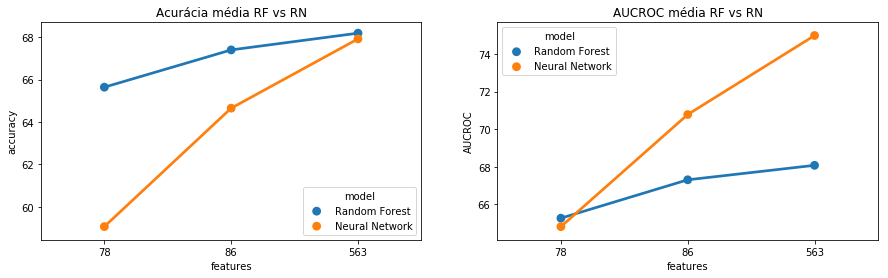

In [367]:
results_acc = [ 
        #C1
        { 'accuracy' : 65.64, 'features' : 78, 'model' : 'Random Forest' },
        { 'accuracy' : 59.06, 'features' : 78, 'model' : 'Neural Network'},
        #C2
        { 'accuracy' : 67.40, 'features' : 86, 'model' : 'Random Forest'},
        { 'accuracy' : 64.65, 'features' : 86, 'model' : 'Neural Network'},
        #C3 
        { 'accuracy' : 68.19, 'features' : 563, 'model' : 'Random Forest'},
        { 'accuracy' : 67.92, 'features' : 563, 'model' : 'Neural Network'}
]

results_roc = [ 
        #C1
        { 'AUCROC' : 65.27, 'features' : 78, 'model' : 'Random Forest' },
        { 'AUCROC' : 64.82, 'features' : 78, 'model' : 'Neural Network'},
        #C2
        { 'AUCROC' : 67.31, 'features' : 86, 'model' : 'Random Forest'},
        { 'AUCROC' : 70.78, 'features' : 86, 'model' : 'Neural Network'},
        #C3 
        { 'AUCROC' : 68.08, 'features' : 563, 'model' : 'Random Forest'},
        { 'AUCROC' : 74.98, 'features' : 563, 'model' : 'Neural Network'}
]

fig, eixos = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

df_results_acc = pd.DataFrame(data=results_acc, columns=['accuracy', 'features', 'model'])
ax = sns.pointplot(data=df_results_acc, x="features", hue="model", y="accuracy", ax=eixos[0])
ax.set_title('Acurácia média RF vs RN')
df_results_roc = pd.DataFrame(data=results_roc, columns=['AUCROC', 'features', 'model'])
ax = sns.pointplot(data=df_results_roc, x="features", hue="model", y="AUCROC", ax=eixos[1])
ax.set_title('AUCROC média RF vs RN')

#### Acurácia

Os experimentos mostraram que com poucos atributos a **Random Forest (RF)** consegue ter um desempenho superior a Rede Neural, mas a medida que o número de atributos aumenta, aumenta a complexidade dos dados e a RF não consegue ter melhorias tão expressivas. 

Quanto o número de atributos saltou para **563** as **Redes Neurais (RN)** tiveram resultados bem melhores comparado com a RF, pois como podemos, a medida que aumenta a complexidade dos dados, a RF se estabiliza entre **65% e 68%** não conseguindo resultados melhores do que isso, enquanto a RN consegue melhorar seu desempenho gratativamente, um ganho de **17%** entre os experimentos. 

É importante frisar que a rede neural experimentada possui somente **2 camadas ocultas** com **10 neurônios** densamente conectados. Uma arquitetura considera simples que foi possível ter bons resultados comparado com um classificador ensemble, que já é considerado muito bom. 

Apesar de a avaliação nessa fase ter sido feito olhando para a **acurácia**, não conseguimos saber de forma geral, qual foi a proporção de positivos e negativos classificado, o que pode nos levar facilmente a uma conclusão errônea. Então iremos avaliar também olhando para a AUCROC, uma métrica mais robusta a critérios de sensibilidade e especificidade. 

#### AUCROC

Avaliando por meio da AUCROC podemos ver claramente a superiodade da **Rede Neural (RN)** em relação a **Random Forest (RF)**, e de novo a medida que novos atributos são adicionados a RF se estabiliza entre 65% e 67%, enquanto a RN cresce expressivamente até alcançar um desempenho de 75%. 

Esta medida AUCROC é usada para comparar sistemas de previsão, realizando o cálculo da medida sob a área da curva ROC (AUC). Na prática o resultado da medida leva em consideração fatores de especificidade e sensibilidade do sistema, de maneira que, quanto maior o valor de AUC melhor é o sistema. 

O interessante da medida é a característica de considerar a proporção dos verdadeiros positivos e os verdadeiros negativos presente nos resultados, respectivamente especificidade e sensibilidade, agregando mais confiança aos resultados do que simplesmente olhar para a acurácia. 

Fonte: http://crsouza.com/2009/07/13/analise-de-poder-discriminativo-atraves-de-curvas-roc/

#### Atributos importantes para a RF

Todos os valores foram extraídos da tabela de experimentos no início desta seção.

- ANO_IN_GRAD
- ANO_FIM_2G
- NU_IDADE
- QE_I07
- QE_I08
- QE_I09
- QE_I11
- QE_I16
- QE_I20
- QE_I22
- QE_I23
- QE_I25
- QE_I26

Temos uma grande quantidade de atributos sobre o candidato, são eles os atributos de questionários QE_I07 a QE_I26. Estes questionários são informações sobre o candidato representando sua renda familiar, se recebe bolsa, quantas horas dedica para estudar, quantos livros já leu segundo a recomendação da bibliografia do curso, entre outras informações. A questão **QE_I16** não consta no anexo, portanto não é possível saber que tipo de informação ela se trata.

Outros atributos listados são sobre a **idade do candidato**, o **ano de início da graduação** e **fim do ensino médio**. Talvez o modelo esteja aprendendo que estudantes que tenham feito um ensino médio a muito tempo e começou a faculdade anos depois possa ter forte influência na decisão a respeito se o estudante irá passar ou não no ENADE. Cabe investigar esta relação em trabalhos futuros.

### Respostas de questionários importantes para a RF

Todos os valores foram extraídos da tabela de experimentos no início desta seção.

- QE_I08
    - QE_I08_0 (A = Menor renda familiar menor que um salário mínimo)
- QE_I11
    - QE_I11_0 (A = Nenhum, pois meu curso é gratuito.)
    - QE_I11_1 (B = Nenhum, embora meu curso não seja gratuito.)
    - QE_I11_2 (C = ProUni integral.)
- QE_I23
    - QE_I23_1 (B = De uma a três)
- QE_I26
    - QE_I26_2 (C = Proximidade da minha residência.)
    - QE_I26_6 (G = Foi a única onde tive aprovação.)
    
Com essas respostas seria interessante uma investigação em trabalhos futuros para analisar-las e verificar se é possível extrair um novo atributo a partir destas informações. A priori deu para ver que todas as respostas privilegiadas são de questionários sobre o candidato relacionado a renda familiar, se recebe incentivo para custear o curso e quantas horas de estudo dedicada.

- **QE_I08**: sabemos corresponde a questão sobre a renda familiar do candidato. E a **resposta A** foi selecionada como a resposta mais importante para a RF. Isso indica que os candidatos com a menor renda familiar são determinante para o modelo.
- **QE_I11**: sabemos que corresponde a bolsa ou incentivo recebido pelo candidato para custear parte ou todas as mensalidades do curso. O interessante deste resultado é notar que para o modelo os estudantes que responderam **A ou B**, aqueles que não recebem nenhum tipo de bolsa tiveram importância maior do que candidatos que participam do ProUni. Talvez seria interessante adicionar um novo atributo para definir se o estudante utiliza bolsa ou não para ajudar o modelo a aprender esta informação.
- **QE_I23**: sabemos que corresponde a quantidade de horas dedicada pelo estudante para estudar. A resposta mais importante foi os candidatos que dedicaram de **1 a 3 horas**.
- **QE_I26**: sabemos que representa o motivo que influenciou o estudante na escolha da instituição. Aqueles que moram perto ou não tiveram opção por nota baixa foram respostas importantes para o modelo determinar se o estudante irá passar ou não. 

### Atributos que podem ser melhorados

Olhando a relação de atributos em anexo, alguns atributos poderiam ser apenas categorizados e outros apenas binarizados, sem aplicar o one hot encoder. Pois levando em consideração as respostas poderia ajudar os classificadores a aprenderem mais rápido estas informações.

#### Binarizar

- **QE_I14** - Durante o curso de graduação você participou de programas e/ou atividades curriculares no exterior? (A=não)
- **QE_I15** - Seu ingresso no curso de graduação se deu por meio de políticas de ação afirmativa ou inclusão social? (A=não)
- **QE_I21** - Alguém em sua família concluiu um curso superior? (A=Sim)
- **QE_I24** - Você teve oportunidade de aprendizado de idioma estrangeiro na Instituição? (E=não)

#### Categorizar 

- **QE_I04** - Até que etapa de escolarização seu pai concluiu?
- **QE_I05** - Até que etapa de escolarização sua mãe concluiu?
- **QE_I22** - Excetuando-se os livros indicados na bibliografia do seu curso, quantos livros você leu neste ano? 
- **QE_I23** - Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula?

## Resultados do experimento 2

<table>
    <head>
        <tr>
            <td><b>RN</b></td>
            <td><b>Acurácia</b></td>
            <td><b>AUCROC</b></td>
            <td><b>Descrição</b></td>
            <td><b>Atributos</b>
        </tr>
    </head>
    <tr>
        <td>Simples</td>
        <td>68.42%</td>
        <td>75.15%</td>
        <td>
            Treino demorado, mas alcançou o melhor resultado<br>
            50 neurônios 2 camadas (Sem batch normalization e dropout)
        </td>
        <td>563</td>
    </tr>
    <tr>
        <td>Normalização em Batch</td>
        <td>66.80%</td>
        <td>73.00%</td>
        <td>
            Treino super rápido, chegou próximo do melhor resultado<br>
            50 neurônios 2 camadas (Com batch normalization)
        </td>
        <td>563</td>
    </tr>
    <tr>
        <td>Dropout</td>
        <td><b>68.69%</b></td>
        <td><b>75.59%</b></td>
        <td>
            Treino demorado, mas alcançou o melhor resultado<br>
            50 neurônios 2 camadas (Com dropout de 20%)
        </td>
        <td>563</td>
    </tr>
</table>

Utilizando apenas o dropout de 20% nas camadas foi possível obter o mesmo resultado da melhor arquitetura do experimento 1. Isso mostra que com poucas configurações já possível obter o melhor desempenho da Rede Neural para este conjunto de dados.

## Resultados do experimento 3

<table>
    <head>
        <tr>
            <td><b>Método</b></td>
            <td><b>Acurácia</b></td>
            <td><b>AUCROC</b></td>
            <td><b>Descrição</b></td>
            <td><b>Atributos</b>
        </tr>
    </head>
    <tr>
        <td>RF</td>
        <td>68.26%</td>
        <td>68.09%</td>
        <td>
            300 árvores<br>
            50 neurônios + 2 camadas (Sem batch normalization e dropout)
        </td>
        <td>565</td>
    </tr>
    <tr>
        <td>RN</td>
        <td>68.81%</td>
        <td>75.39%</td>
        <td>
            Simples + Normalização em Batch + Dropout<br>
            50 neurônios + 2 camadas
        </td>
        <td>565</td>
    </tr>
    <tr>
        <td>RN</td>
        <td><b>69.33%</b></td>
        <td><b>75.86%</b></td>
        <td>
            Simples + Normalização em Batch + Dropout<br>
            50 neurônios para cada uma das **4 camadas ocultas**
            Dropout de 50%
        </td>
        <td>565</td>
    </tr>
</table>

Testando com 2 camadas + Dropout + Normalização em Batch não foi possível ter resultado melhor mesmo adicionando mais atributos que poderiam ajudar a Rede Neural e a Ranfom Forest. Diante disso, adicionamos 2 camadas na arquitetura do melhor resultado, totalizando **4 camadas ocultas** na rede. 

Nesse contexto, conseguimos obter uma acurácia de **69.33%** e uma AUCROC de **75.86%**, ultrapassando os melhores resultados dos **experimentos 1 e 2**. Isso mostrou que adicionando mais camadas automaticamente estamos aumentando a capacidade da nossa rede e transformando o modelo em um modelo mais complexo a medida que adicionamos camadas. 

Para experimentos futuros, seria interessante rodar vários vezes um número maior de camadas e testar até onde este tipo de arquitetura de redes neurais podem alcançar para este problema.  

## ANEXO: Dicionário de Dados

**Dados da IES**

| **Coluna** | **Descrição** | **Valores** |
|--:|:--|:--|
| CO_IES | Código da IES (e-Mec) |  |
| CO_CATEGAD | Código da categoria administrativa da IES | 10002 = Pessoa Jurídica de Direito Público - Federal<br>10005 = Privada com fins lucrativos<br>10008 = Privada sem fins lucrativos |
| CO_ORGACAD | Código da organização acadêmica da IES | 10020 = Centro Universitário<br>10022 = Faculdade<br>10026 = Instituto Federal de Educação, Ciência e Tecnologia<br>10028 = Universidade |
| CO_GRUPO | Código da área de enquadramento do curso no Enade | 4004 = CIÊNCIA DA COMPUTAÇÃO (BACHARELADO)<br> 4006 = SISTEMAS DE INFORMAÇÃO |
| CO_UF_CURSO | Código da UF de funcionamento do curso | SP MG RS RJ SC PR PE DF BA CE GO AM PA PB MA ES MT PI MS AL RO TO SE RN AC RR AP | 
| CO_REGIAO_CURSO | Código da região de funcionamento do curso | 1 = Norte<br>2 = Nordeste<br>3 = Sudeste<br>4 = Sul<br>5 = Centro-Oeste |

**Dados dos Participantes**

| **Coluna** | **Descrição** | **Valores** |
|--:|:--|:--|
| NU_IDADE | Idade do inscrito em 23/11/2014 |  |
| TP_SEXO | Sexo | M = Masculino <br>F = Feminino |
| ANO_FIM_2G | Ano de conclusão do Ensino Médio |  |
| ANO_IN_GRAD | Ano de início da graduação |  |
| IN_MATUT | Indicador de turno matutino | 0 = Não <br>1 = Sim |
| IN_VESPER | Indicador de turno vespertino | 0 = Não <br>1 = Sim |
| IN_NOTURNO | Indicador de turno noturno | 0 = Não <br>1 = Sim |


**Notas dos Participantes**

| **Coluna** | **Descrição** |
|--:|:--|
| NT_GER | Nota bruta da prova - Média ponderada da formação geral (25%) e componente específico (75%). (valor de 0 a 100) |
| NT_FG | Nota bruta na formação geral - Média ponderada da parte objetiva (60%) e discursiva (40%) na formação geral.(valor de 0 a 100) |
| NT_OBJ_FG | Nota bruta na parte objetiva da formação geral. (valor de 0 a 100) |
| NT_DIS_FG | Nota bruta na parte discursiva da formação geral. (valor de 0 a 100) |
| NT_FG_D1 | Nota da questão 1 da parte discursiva da formação geral - Média ponderada da parte de Língua Portuguesa (20%) e Conteúdo (80%) da Questão 1 da parte discursiva. (valor de 0 a 100) |
| NT_FG_D1_PT | Nota de Língua Portuguesa da questão 1 da parte discursiva da formação geral. (valor de 0 a 100) |
| NT_FG_D1_CT | Nota de Conteúdo da questão 1 da parte discursiva da formação geral. (valor de 0 a 100)  |
| NT_FG_D2 | Nota da questão 2 da parte discursiva na formação geral - Média ponderada da parte de Língua Portuguesa (20%) e Conteúdo (80%) da Questão 2 da parte discursiva. (valor de 0 a 100) |
| NT_FG_D2_PT | Nota de Língua Portuguesa da questão 2 da parte discursiva da formação geral.(valor de 0 a 100)  |
| NT_FG_D2_CT | Nota de Conteúdo da questão 2 da parte discursiva da formação geral. (valor de 0 a 100)  |
| NT_CE | Nota bruta no componente específico - Média ponderada da parte objetiva (85%) e discursiva (15%) no componente específico. (valor de 0 a 100) |
| NT_OBJ_CE | Nota bruta na parte objetiva do componente específico. (valor de 0 a 100)  |
| NT_DIS_CE | Nota bruta na parte discursiva do componente específico. (valor de 0 a 100) |
| NT_CE_D1 | Nota da questão 1 da parte discursiva do componente específico. (valor de 0 a 100)  |
| NT_CE_D2 | Nota da questão 2 da parte discursiva do componente específico. (valor de 0 a 100)  |
| NT_CE_D3 | Nota da questão 3 da parte discursiva do componente específico. (valor de 0 a 100)  |

## Respostas aos Questionários

**Questionário sobre a prova**

| **Coluna** | **Descrição** | **Valores** |
|--:|:--|:--|
| CO_RS_I1 | 1 - Qual o grau de dificuldade desta prova na parte de Formação Geral? | A = Muito fácil.<br>B = Fácil.<br>C = Médio.<br>D = Difícil.<br>E = Muito difícil.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I2 | 2 - Qual o grau de dificuldade desta prova na parte do Componente Específico? | A = Muito fácil.<br>B = Fácil.<br>C = Médio.<br>D = Difícil.<br>E = Muito difícil.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I3 | 3 - Considerando a extensão da prova, em relação ao tempo total, você considera que a prova foi: | A = Muito longa.<br>B = Longa.<br>C = Adequada.<br>D = Curta.<br>E = Muito curta.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I4 | 4 - Os enunciados das questões da prova na parte de Formação Geral estavam claros e objetivos? | A = Muito fácil.<br>B = Fácil.<br>C = Médio.<br>D = Difícil.<br>E = Muito difícil.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I5 | 5 - Os enunciados das questões na parte do Componente Específico estavam claros e objetivos? | A = Muito fácil.<br>B = Fácil.<br>C = Médio.<br>D = Difícil.<br>E = Muito difícil.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I6 | 6 - As informações/instruções fornecidas para a resolução das questões foram suficientes para resolvê-las? | A = Sim, até excessivas.<br>B = Sim, em todas elas.<br>C = Sim, na maioria delas.<br>D = Sim, somente em algumas.<br>E = Não, em nenhuma delas.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I7 | 7 - Você se deparou com alguma dificuldade ao responder à prova. Qual? | A = Desconhecimento do conteúdo.<br>B = Forma diferente de abordagem do conteúdo.<br>C = Espaço insuficiente para responder às questões.<br>D = Falta de motivação para fazer a prova.<br>E = Não tive qualquer tipo de dificuldade para responder à prova.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I8 | 8 - Considerando apenas as questões objetivas da prova, você percebeu que: | A = Não estudou ainda a maioria desses conteúdos.<br>B = Estudou alguns desses conteúdos, mas não os aprendeu.<br>C = Estudou a maioria desses conteúdos, mas não os aprendeu.<br>D = Estudou e aprendeu muitos desses conteúdos.<br>E = Estudou e aprendeu todos esses conteúdos.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I9 | 9 - Qual foi o tempo gasto por você para concluir a prova? | A = Menos de uma hora.<br>B = Entre uma e duas horas.<br>C = Entre duas e três horas.<br>D = Entre três e quatro horas.<br>E = Quatro horas e não consegui terminar.<br>* = Resposta anulada<br>. = Não respondeu |

**Questionário sobre o candidato**

| **Coluna** | **Descrição** | **Valores** |
|--:|:--|:--|
| QE_I01 | Qual o seu estado civil? | A = Solteiro(a).<br>B = Casado(a).<br>C = Separado(a) judicialmente/divorciado(a).<br>D = Viúvo(a).<br>E = Outro. |
| QE_I02 | Como você se considera? | A = Branco(a).<br>B = Negro(a).<br>C = Pardo(a)/mulato(a).<br>D = Amarelo(a) (de origem oriental).<br>E = Indígena ou de origem indígena. |
| QE_I03 | Qual a sua nacionalidade? | A = Brasileira.<br>B = Brasileira naturalizada.<br>C = Estrangeira. |
| QE_I04 | Até que etapa de escolarização seu pai concluiu? | A = Nenhuma.<br>B = Ensino Fundamental: 1º ao 5º ano (1ª a 4ª série).<br>C = Ensino Fundamental: 6º ao 9º ano (5ª a 8ª série).<br>D = Ensino Médio.<br>E = Ensino Superior - Graduação.<br>F = Pós-graduação. |
| QE_I05 | Até que etapa de escolarização sua mãe concluiu? | A = Nenhuma.<br>B = Ensino fundamental: 1º ao 5º ano (1ª a 4ª série).<br>C = Ensino fundamental: 6º ao 9º ano (5ª a 8ª série).<br>D = Ensino médio.<br>E = Ensino Superior - Graduação.<br>F = Pós-graduação. |
| QE_I06 | Onde e com quem você mora atualmente? | A = Em casa ou apartamento, sozinho.<br>B = Em casa ou apartamento, com pais e/ou parentes.<br>C = Em casa ou apartamento, com cônjuge e/ou filhos.<br>D = Em casa ou apartamento, com outras pessoas (incluindo república).<br>E = Em alojamento universitário da própria instituição.<br>F = Em outros tipos de habitação individual ou coletiva (hotel, hospedaria, pensão ou outro) |
| QE_I07 | Quantas pessoas da sua família moram com você? Considere seus pais, irmãos, cônjuge, filhos e outros parentes que moram na mesma casa com você. | A = Nenhuma.<br>B = Uma.<br>C = Duas.<br>D = Três.<br>E = Quatro.<br>F = Cinco.<br>G = Seis.<br>H = Sete ou mais. |
| QE_I08 | Qual a renda total de sua família, incluindo seus rendimentos? | A = Até 1,5 salário mínimo (até R\$ 1.086,00).<br>B = De 1,5 a 3 salários mínimos (R\$ 1.086,01 a R\$ 2.172,00).<br>C = De 3 a 4,5 salários mínimos (R\$ 2.172,01 a R\$ 3.258,00).<br>D = De 4,5 a 6 salários mínimos (R\$ 3.258,01 a R\$ 4.344,00).<br>E = De 6 a 10 salários mínimos (R\$ 4.344,01 a R\$ 7.240,00).<br>F = De 10 a 30 salários mínimos (R\$ 7.240,01 a R\$ 21.720,00).<br>G = Acima de 30 salários mínimos (mais de R\$ 21.720,01). |
| QE_I09 | Qual alternativa a seguir melhor descreve sua situação financeira (incluindo bolsas)? | A = Não tenho renda e meus gastos são financiados por programas governamentais.<br>B = Não tenho renda e meus gastos são financiados pela minha família ou por outras pessoas.<br>C = Tenho renda, mas recebo ajuda da família ou de outras pessoas para financiar meus gastos.<br>D = Tenho renda e não preciso de ajuda para financiar meus gastos.<br>E = Tenho renda e contribuo com o sustento da família.<br>F = Sou o principal responsável pelo sustento da família. |
| QE_I10 | Qual alternativa a seguir melhor descreve sua situação de trabalho (exceto estágio ou bolsas)? | A = Não estou trabalhando.<br>B = Trabalho eventualmente.<br>C = Trabalho até 20 horas semanais.<br>D = Trabalho de 21 a 39 horas semanais.<br>E = Trabalho 40 horas semanais ou mais. |
| QE_I11 | Que tipo de bolsa de estudos ou financiamento do curso você recebeu para custear todas ou a maior parte das mensalidades? No caso de haver mais de uma opção, marcar apenas a bolsa de maior duração. | A = Nenhum, pois meu curso é gratuito.<br>B = Nenhum, embora meu curso não seja gratuito.<br>C = ProUni integral.<br>D = ProUni parcial, apenas.<br>E = FIES, apenas.<br>F = ProUni Parcial e FIES.<br>G = Bolsa oferecida por governo estadual, distrital ou municipal.<br>H = Bolsa oferecida pela própria instituição.<br>I = Bolsa oferecida por outra entidade (empresa, ONG, outra).<br>J = Financiamento oferecido pela própria instituição.<br>K = Financiamento bancário. |
| QE_I12 | Ao longo da sua trajetória acadêmica, você recebeu algum tipo de auxílio permanência? No caso de haver mais de uma opção, marcar apenas a bolsa de maior duração. | A = Nenhum.<br>B = Auxílio moradia.<br>C = Auxílio alimentação.<br>D = Auxílio moradia e alimentação.<br>E = Auxílio permanência.<br>F = Outro tipo de auxílio. |
| QE_I13 | Ao longo da sua trajetória acadêmica, você recebeu algum tipo de bolsa acadêmica? No caso de haver mais de uma opção, marcar apenas a bolsa de maior duração. | A = Nenhum.<br>B = Bolsa de iniciação científica.<br>C = Bolsa de extensão.<br>D = Bolsa de monitoria/tutoria.<br>E = Bolsa PET.<br>F = Outro tipo de bolsa acadêmica. |
| QE_I14 | Durante o curso de graduação você participou de programas e/ou atividades curriculares no exterior? | A = Não participei.<br>B = Sim, Programa Ciência sem Fronteiras.<br>C = Sim, programa de intercâmbio financiado pelo Governo Federal (Marca; Brafitec; PLI; outro).<br>D = Sim, programa de intercâmbio financiado pelo Governo Estadual.<br>E = Sim, programa de intercâmbio da minha instituição.<br>F = Sim, outro intercâmbio não institucional. |
| QE_I15 | Seu ingresso no curso de graduação se deu por meio de políticas de ação afirmativa ou inclusão social? | A = Não.<br>B = Sim, por critério étnico-racial.<br>C = Sim, por critério de renda.<br>D = Sim, por ter estudado em escola pública ou particular com bolsa de estudos.<br>E = Sim, por sistema que combina dois ou mais critérios anteriores.<br>F = Sim, por sistema diferente dos anteriores. |
| QE_I17 | Em que tipo de escola você cursou o ensino médio? | A = Todo em escola pública.<br>B = Todo em escola privada (particular).<br>C = Todo no exterior.<br>D = A maior parte em escola pública.<br>E = A maior parte em escola privada (particular).<br>F = Parte no Brasil e parte no exterior. |
| QE_I18 | Qual modalidade de ensino médio você concluiu? | A = Ensino médio tradicional.<br>B = Profissionalizante técnico (eletrônica, contabilidade, agrícola, outro).<br>C = Profissionalizante magistério (Curso Normal).<br>D = Educação de Jovens e Adultos (EJA) e/ou Supletivo.<br>E = Outra modalidade. |
| QE_I19 | Quem lhe deu maior incentivo para cursar a graduação? | A = Ninguém.<br>B = Pais.<br>C = Outros membros da família que não os pais.<br>D = Professores.<br>E = Líder ou representante religioso.<br>F = Colegas/Amigos.<br>G = Outras pessoas. |
| QE_I20 | Algum dos grupos abaixo foi determinante para você enfrentar dificuldades durante seu curso superior e concluí-lo? | A = Não tive dificuldade.<br>B = Não recebi apoio para enfrentar dificuldades.<br>C = Pais.<br>D = Avós.<br>E = Irmãos, primos ou tios.<br>F = Líder ou representante religioso.<br>G = Colegas de curso ou amigos.<br>H = Professores do curso.<br>I = Profissionais do serviço de apoio ao estudante da IES.<br>J = Colegas de trabalho.<br>K = Outro grupo. |
| QE_I21 | Alguém em sua família concluiu um curso superior? | A = Sim.<br>B = Não. |
| QE_I22 | Excetuando-se os livros indicados na bibliografia do seu curso, quantos livros você leu neste ano? |A = Nenhum.<br>B = Um ou dois.<br>C = De três a cinco.<br>D = De seis a oito.<br>E = Mais de oito. |
| QE_I23 | Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula? | A = Nenhuma, apenas assisto às aulas.<br>B = De uma a três.<br>C = De quatro a sete.<br>D = De oito a doze.<br>E = Mais de doze. |
| QE_I24 | Você teve oportunidade de aprendizado de idioma estrangeiro na Instituição? | A = Sim, somente na modalidade presencial.<br>B = Sim, somente na modalidade semipresencial.<br>C = Sim, parte na modalidade presencial e parte na modalidade semipresencial.<br>D = Sim, na modalidade a distância.<br>E = Não. |
| QE_I25 | Qual o principal motivo para você ter escolhido este curso? | A = Inserção no mercado de trabalho.<br>B = Influência familiar.<br>C = Valorização profissional.<br>D = Prestígio Social.<br>E = Vocação.<br>F = Oferecido na modalidade a distância.<br>G = Baixa concorrência para ingresso.<br>H = Outro motivo. |
| QE_I26 | Qual a principal razão para você ter escolhido a sua instituição de educação superior? | A = Gratuidade.<br>B = Preço da mensalidade.<br>C = Proximidade da minha residência.<br>D = Proximidade do meu trabalho.<br>E = Facilidade de acesso.<br>F = Qualidade/reputação.<br>G = Foi a única onde tive aprovação.<br>H = Possibilidade de ter bolsa de estudo.<br>I = Outro motivo. |

**Questionário sobre o curso**

| **Coluna** | **Descrição** | **Valores** |
|--:|:--|:--|
| QE_I27 | As disciplinas cursadas contribuíram para sua formação integral, como cidadão e profissional. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I28 | Os conteúdos abordados nas disciplinas do curso favoreceram sua atuação em estágios ou em atividades de iniciação profissional. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I29 | As metodologias de ensino utilizadas no curso desafiaram você a aprofundar conhecimentos e desenvolver competências reflexivas e críticas. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I30 | O curso propiciou experiências de aprendizagem inovadoras. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I31 | O curso contribuiu para o desenvolvimento da sua consciência ética para o exercício profissional. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I32 | No curso você teve oportunidade de aprender a trabalhar em equipe. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I33 | O curso possibilitou aumentar sua capacidade de reflexão e argumentação. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I34 | O curso promoveu o desenvolvimento da sua capacidade de pensar criticamente, analisar e refletir sobre soluções para problemas da sociedade. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I35 | O curso contribuiu para você ampliar sua capacidade de comunicação nas formas oral e escrita. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I36 | O curso contribuiu para o desenvolvimento da sua capacidade de aprender e atualizar-se permanentemente. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I37 | As relações professor-aluno ao longo do curso estimularam você a estudar e aprender. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I38 | Os planos de ensino apresentados pelos professores contribuíram para o desenvolvimento das atividades acadêmicas e para seus estudos. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I39 | As referências bibliográficas indicadas pelos professores nos planos de ensino contribuíram para seus estudos e aprendizagens. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I40 | Foram oferecidas oportunidades para os estudantes superarem dificuldades relacionadas ao processo de formação. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I41 | A coordenação do curso esteve disponível para orientação acadêmica dos estudantes. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I42 | O curso exigiu de você organização e dedicação frequente aos estudos. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I43 | Foram oferecidas oportunidades para os estudantes participarem de programas, projetos ou atividades de extensão universitária. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I44 | Foram oferecidas oportunidades para os estudantes participarem de projetos de iniciação científica e de atividades que estimularam a investigação acadêmica. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I45 | O curso ofereceu condições para os estudantes participarem de eventos internos e/ou externos à instituição. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I46 | A instituição ofereceu oportunidades para os estudantes atuarem como representantes em órgãos colegiados. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I47 | O curso favoreceu a articulação do conhecimento teórico com atividades práticas. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I48 | As atividades práticas foram suficientes para relacionar os conteúdos do curso com a prática, contribuindo para sua formação profissional. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I49 | O curso propiciou acesso a conhecimentos atualizados e/ou contemporâneos em sua área de formação. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I50 | O estágio supervisionado proporcionou experiências diversificadas para a sua formação. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I51 | As atividades realizadas durante seu trabalho de conclusão de curso contribuíram para qualificar sua formação profissional | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I52 | Foram oferecidas oportunidades para os estudantes realizarem intercâmbios e/ou estágios no país. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I53 | Foram oferecidas oportunidades para os estudantes realizarem intercâmbios e/ou estágios fora do país. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I54 | Os estudantes participaram de avaliações periódicas do curso (disciplinas, atuação dos professores, infraestrutura). | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I55 | As avaliações da aprendizagem realizadas durante o curso foram compatíveis com os conteúdos ou temas trabalhados pelos professores. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I56 | Os professores apresentaram disponibilidade para atender os estudantes fora do horário das aulas. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I57 | Os professores demonstraram domínio dos conteúdos abordados nas disciplinas. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I58 | Os professores utilizaram tecnologias da informação e comunicação (TICs) como estratégia de ensino (projetor multimídia, laboratório de informática, ambiente virtual de aprendizagem). | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I59 | A instituição dispôs de quantidade suficiente de funcionários para o apoio administrativo e acadêmico. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I60 | O curso disponibilizou monitores ou tutores para auxiliar os estudantes. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I61 | As condições de infraestrutura das salas de aula foram adequadas. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I62 | Os equipamentos e materiais disponíveis para as aulas práticas foram adequados para a quantidade de estudantes. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I63 | Os ambientes e equipamentos destinados às aulas práticas foram adequados ao curso. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I64 | A biblioteca dispôs das referências bibliográficas que os estudantes necessitaram. |1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I65 | A instituição contou com biblioteca virtual ou conferiu acesso a obras disponíveis em acervos virtuais. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I66 | As atividades acadêmicas desenvolvidas dentro e fora da sala de aula possibilitaram reflexão, convivência e respeito à diversidade. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I67 | A instituição promoveu atividades de cultura, de lazer e de interação social. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I68 | A instituição dispôs de refeitório, cantina e banheiros em condições adequadas que atenderam as necessidades dos seus usuários. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |